# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


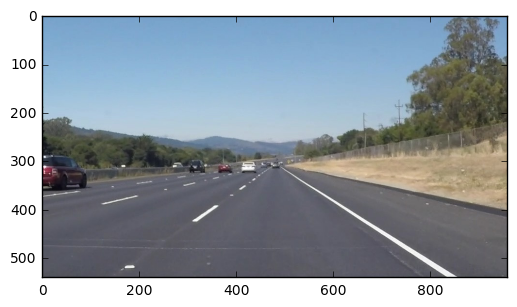

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

hi
[[[159 538 330 414]]

 [[264 472 426 350]]

 [[299 438 421 350]]

 [[177 539 340 416]]

 [[286 447 348 401]]

 [[178 539 243 490]]

 [[231 487 297 438]]

 [[160 538 216 498]]

 [[237 493 425 351]]

 [[311 429 362 391]]

 [[325 419 379 379]]]


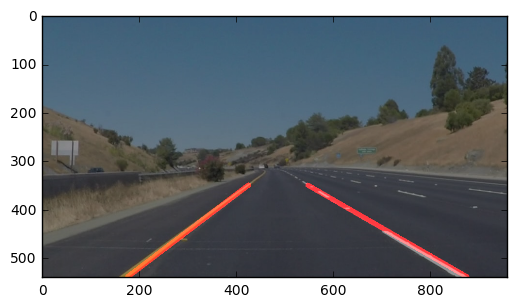

In [89]:
def process_image(image):
    # convert to grayscale
    print('hi')
    gray = grayscale(image)

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define parameters for Canny and run it
    low_threshold = 50
    high_threshold = 150
    edges = canny(gray, low_threshold, high_threshold)

    # Mask the edges
    top = 350
    bottom = 539
    
    bottom_left = (100, bottom)
    bottom_right = (950, bottom)
    bottom_middle = (525,bottom)
    top_left = (400,top)
    top_right = (600,top)
    top_middle = (500,top)
    
    vertices_left = np.array([[bottom_left,top_left,top_middle,bottom_middle]], dtype=np.int32)
    vertices_right = np.array([[bottom_right,top_right,top_middle,bottom_middle]], dtype=np.int32)
    
    masked_edges_left = region_of_interest(edges, vertices_left)
    masked_edges_right = region_of_interest(edges, vertices_right)

    # Define the Hough transform parameters
    rho = 1
    theta = np.pi/180
    threshold = 15
    min_line_len = 40
    max_line_gap = 20

    # Get Hough Lines from masked edges
    lines_left = cv2.HoughLinesP(masked_edges_left, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines_right = cv2.HoughLinesP(masked_edges_right, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    print(lines_left)
    
    # Create background for lines
    line_img = np.zeros((*edges.shape, 3), dtype=np.uint8)
    
    if(lines_left != None and lines_right != None):
        # For left lines, get top point
        index_top_left = lines_left[:,:,3].argmin() # find the index of the line that has the lowest value (highest in pic) 
        x_top_left = lines_left[index_top_left][0][2] # get the x value there
        y_top_left = lines_left[index_top_left][0][3] # get the y value there

        # For left lines, get bottom point
        index_bottom_left = lines_left[:,:,1].argmax()
        x_bottom_left = lines_left[index_bottom_left][0][0]
        y_bottom_left = lines_left[index_bottom_left][0][1]

        # For right lines get top point
        index_top_right = lines_right[:,:,1].argmin()
        y_top_right = lines_right[index_top_right][0][1]
        x_top_right = lines_right[index_top_right][0][0]

        # For right lines, get bottom point
        index_bottom_right = lines_right[:,:,3].argmax()
        x_bottom_right = lines_right[index_bottom_right][0][2]
        y_bottom_right = lines_right[index_bottom_right][0][3]

        # Determine slopes
        slope_left = (y_top_left-y_bottom_left)/(x_top_left-x_bottom_left)
        slope_right = (y_top_right-y_bottom_right)/(x_top_right-x_bottom_right)

        #determine y intercepts: b = y - mx
        y_intercept_left = y_top_left - slope_left*x_top_left
        y_intercept_right = y_top_right - slope_right*x_top_right

        # Create the lines, given y spans from top to bottom x=(y-b)/m
        y_low_left = bottom
        x_low_left = int((y_low_left - y_intercept_left)/slope_left)
        y_high_left = top
        x_high_left = int((y_high_left - y_intercept_left)/slope_left)

        y_low_right = bottom
        x_low_right = int((y_low_right - y_intercept_right)/slope_right)
        y_high_right = top
        x_high_right = int((y_high_right - y_intercept_right)/slope_right)

        right_line = np.array([[[x_low_right,y_low_right,x_high_right,y_high_right]]])
        left_line = np.array([[[x_low_left,y_low_left,x_high_left,y_high_left]]])

        # Draw lines
        draw_lines(line_img, right_line, color=[255, 0, 0], thickness=10)
        draw_lines(line_img, left_line, color=[255, 0, 0], thickness=10)

    # Overlay Hough lines onto original image
    result = weighted_img(line_img, image, α=0.6, β=1., λ=0.)
    return result

# get list of test images
import os
images = os.listdir('./test_images')

# read the image
path = 'test_images/' + images[3]
image = mpimg.imread(path)
result = process_image(image)
    
# Display the image
plt.imshow(result)

#### run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [61]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [90]:
clip0 = VideoFileClip("solidWhiteRight.mp4")
image = clip0.get_frame(6/25)
result = process_image(image)
# plt.imshow(result)
# plt.imshow(image)

hi
None


Let's try the one with the solid white lane on the right first ...

In [91]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

hi
[[[187 514 302 430]]

 [[217 504 310 432]]

 [[205 513 282 453]]

 [[187 512 301 430]]

 [[248 481 311 432]]]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  3%|▎         | 7/222 [00:00<00:03, 62.77it/s]

hi
[[[187 514 302 430]]

 [[217 504 310 432]]

 [[205 513 282 453]]

 [[187 512 301 430]]

 [[248 481 311 432]]]
hi
[[[150 539 277 447]]

 [[169 539 289 449]]

 [[168 539 289 448]]

 [[155 536 280 446]]]
hi
[[[169 539 262 469]]

 [[149 539 247 468]]

 [[153 537 250 467]]

 [[168 539 265 466]]]
hi
[[[148 538 211 494]]

 [[168 539 225 496]]

 [[167 539 230 492]]

 [[159 530 210 494]]

 [[369 381 409 353]]]
hi
[[[360 388 407 355]]

 [[365 389 409 357]]]
hi
[[[352 392 414 350]]

 [[360 394 419 350]]

 [[358 395 404 358]]

 [[351 394 400 360]]]
hi
None
hi
[[[326 410 367 383]]]
hi
[[[309 424 357 390]]

 [[309 422 354 391]]

 [[317 425 362 392]]

 [[315 425 361 392]]]
hi
[[[300 440 351 401]]

 [[289 439 346 399]]

 [[299 440 349 402]]]
hi
[[[275 460 339 412]]

 [[263 459 333 410]]

 [[263 458 331 410]]

 [[273 461 340 410]]

 [[379 382 425 350]]

 [[374 382 422 350]]

 [[264 458 304 430]]]
hi
[[[243 484 325 422]]

 [[229 483 318 421]]

 [[233 479 314 422]]

 [[241 485 322 424]]

 [[231 481 31

  9%|▉         | 21/222 [00:00<00:03, 63.20it/s]

[[[183 514 300 432]]

 [[201 514 307 434]]

 [[183 513 297 433]]

 [[196 516 307 433]]

 [[183 515 231 481]]]
hi
[[[144 538 275 447]]

 [[163 539 285 447]]

 [[183 525 285 448]]

 [[162 539 206 506]]

 [[146 538 246 468]]]
hi
[[[160 539 258 465]]

 [[141 539 247 465]]

 [[161 539 258 466]]

 [[143 538 248 465]]

 [[192 502 237 471]]]
hi
[[[155 539 232 483]]

 [[156 539 232 484]]

 [[139 537 210 489]]

 [[368 379 408 351]]

 [[141 536 193 499]]]
hi
[[[367 385 409 354]]]
hi
[[[355 393 406 357]]]
hi
[[[357 395 413 352]]

 [[350 400 412 350]]]
hi
[[[326 410 368 384]]

 [[214 487 254 479]]]
hi
[[[320 425 363 392]]

 [[310 423 356 392]]

 [[312 422 358 392]]

 [[319 425 362 392]]]
hi
[[[289 437 348 399]]

 [[300 439 352 401]]

 [[301 439 352 400]]]
hi
[[[274 457 341 410]]

 [[264 454 333 408]]

 [[264 455 335 407]]

 [[273 457 340 410]]]
hi
[[[244 479 327 419]]

 [[232 477 316 418]]

 [[243 479 305 434]]

 [[245 479 324 422]]

 [[269 450 317 418]]

 [[260 458 306 426]]]
hi
[[[202 510 310 432

 16%|█▌        | 35/222 [00:00<00:02, 64.52it/s]

[[[141 539 251 465]]

 [[164 539 262 468]]

 [[147 536 253 465]]

 [[162 539 262 467]]

 [[182 511 250 465]]]
hi
[[[162 539 245 479]]

 [[143 538 213 491]]

 [[373 384 413 356]]

 [[370 383 410 354]]

 [[181 527 224 495]]

 [[149 535 189 508]]]
hi
[[[362 387 406 357]]

 [[366 390 422 350]]

 [[362 388 407 357]]

 [[369 389 410 359]]]
hi
[[[352 394 416 351]]

 [[360 395 416 350]]]
hi
[[[211 478 255 482]]

 [[346 403 419 350]]]
hi
None
hi
[[[311 421 355 390]]

 [[311 422 358 389]]

 [[319 423 363 391]]

 [[318 423 361 392]]

 [[320 423 363 392]]]
hi
[[[292 435 347 397]]

 [[300 437 351 400]]

 [[292 434 344 398]]

 [[301 437 353 400]]]
hi
[[[278 455 342 408]]

 [[267 453 333 407]]

 [[267 454 335 406]]

 [[286 450 342 407]]]
hi
[[[248 478 328 420]]

 [[235 476 320 417]]

 [[246 478 328 419]]

 [[235 477 321 417]]]
hi
[[[208 508 312 430]]

 [[192 507 302 430]]

 [[228 494 311 432]]

 [[204 510 255 472]]]
hi
[[[145 539 279 445]]

 [[172 535 291 446]]

 [[165 539 235 487]]

 [[225 496 291 4

 19%|█▉        | 42/222 [00:00<00:02, 64.76it/s]

hi
[[[365 383 406 354]]

 [[363 386 408 354]]]
hi
[[[361 393 406 358]]

 [[354 392 402 357]]

 [[359 393 406 357]]]
hi
[[[351 400 413 351]]

 [[343 399 411 351]]

 [[353 399 416 350]]]
hi
None
hi
[[[314 418 358 387]]

 [[316 417 357 388]]

 [[323 420 364 389]]]
hi
[[[295 432 346 395]]

 [[303 434 354 396]]

 [[305 434 354 397]]

 [[295 433 349 394]]]
hi
[[[281 450 343 404]]

 [[277 443 337 402]]

 [[270 448 310 421]]]


 24%|██▍       | 53/222 [00:01<00:03, 42.27it/s]

hi
[[[240 469 320 413]]

 [[241 481 329 415]]

 [[251 472 329 413]]

 [[242 468 284 439]]]
hi
[[[211 502 313 425]]

 [[197 499 303 425]]

 [[215 500 313 426]]

 [[198 500 306 424]]

 [[235 472 302 425]]]
hi
[[[140 539 283 439]]

 [[169 533 292 441]]

 [[160 539 256 467]]

 [[238 482 292 442]]

 [[140 538 280 440]]]
hi
[[[139 539 255 458]]

 [[168 533 266 460]]

 [[159 539 242 477]]

 [[209 503 265 461]]

 [[139 538 253 458]]

 [[154 529 256 458]]]
hi
[[[137 539 219 482]]

 [[157 539 237 481]]

 [[137 538 217 482]]

 [[367 378 410 351]]

 [[370 381 410 352]]

 [[157 538 235 481]]]
hi
[[[155 539 196 509]]

 [[358 384 405 353]]]
hi
[[[348 392 399 356]]

 [[193 480 255 479]]

 [[197 478 238 478]]

 [[353 393 402 358]]]
hi
None


 28%|██▊       | 63/222 [00:01<00:04, 39.65it/s]

hi
None
hi
[[[314 415 354 390]]

 [[314 423 357 392]]

 [[307 420 355 390]]

 [[317 422 358 392]]]
hi
[[[285 436 342 398]]

 [[293 438 347 401]]

 [[285 435 340 398]]

 [[296 437 343 404]]]
hi
[[[272 454 335 407]]

 [[260 452 329 406]]

 [[269 455 335 409]]

 [[370 379 410 354]]]
hi
[[[240 476 321 417]]

 [[226 474 313 416]]

 [[274 452 321 418]]

 [[238 476 283 444]]

 [[232 471 286 435]]]
hi
[[[193 508 303 431]]

 [[181 505 294 429]]

 [[196 507 287 443]]

 [[181 506 295 429]]

 [[234 479 303 430]]]
hi
[[[131 539 272 444]]

 [[148 539 281 446]]

 [[150 539 281 447]]

 [[235 478 279 447]]

 [[131 538 240 464]]

 [[133 538 273 444]]]
hi
[[[131 539 248 460]]

 [[151 526 250 460]]

 [[151 539 252 466]]

 [[167 528 252 467]]]


 31%|███       | 68/222 [00:01<00:04, 38.32it/s]

hi
[[[131 538 214 484]]

 [[165 529 215 493]]

 [[149 539 215 491]]

 [[130 539 182 505]]

 [[365 381 406 354]]

 [[366 381 408 354]]

 [[171 511 212 484]]]
hi
[[[363 388 417 350]]

 [[364 381 415 350]]

 [[362 388 416 350]]]
hi
[[[352 394 417 350]]

 [[347 393 411 351]]]
hi
None
hi
[[[322 408 362 382]]

 [[326 409 366 384]]

 [[214 478 254 479]]]
hi
[[[306 418 354 388]]

 [[314 420 357 389]]]
hi
[[[295 433 347 397]]

 [[298 432 347 398]]

 [[286 431 344 395]]]
hi


 34%|███▍      | 76/222 [00:01<00:03, 36.85it/s]

[[[272 449 335 405]]

 [[284 432 329 404]]

 [[261 447 332 403]]

 [[273 449 335 406]]]
hi
[[[229 470 313 413]]

 [[246 467 321 415]]

 [[240 470 322 413]]

 [[229 468 298 422]]

 [[229 469 309 415]]

 [[241 470 321 414]]]
hi
[[[202 498 304 427]]

 [[187 496 297 425]]

 [[199 499 304 426]]

 [[220 474 293 426]]

 [[187 497 230 469]]]
hi
[[[144 538 283 441]]

 [[127 537 209 483]]

 [[132 532 274 440]]

 [[177 516 283 442]]

 [[161 526 258 458]]

 [[127 536 236 465]]

 [[217 476 263 446]]]
hi
[[[144 538 256 460]]

 [[122 539 245 459]]

 [[141 539 217 486]]

 [[131 532 243 459]]

 [[210 481 262 480]]]
hi
[[[120 539 208 482]]

 [[138 539 221 483]]

 [[363 380 406 352]]

 [[363 379 405 352]]

 [[139 539 221 484]]

 [[128 534 205 484]]

 [[171 516 221 482]]]
hi
[[[354 385 402 354]]

 [[118 539 159 513]]

 [[361 385 404 356]]

 [[360 385 404 354]]

 [[356 383 400 354]]]
hi
[[[350 392 412 350]]

 [[344 391 397 357]]]
hi


 39%|███▊      | 86/222 [00:01<00:03, 39.38it/s]

[[[342 399 407 352]]]
hi
[[[319 409 359 382]]

 [[319 406 360 382]]]
hi
[[[309 419 355 388]]

 [[302 418 348 388]]

 [[302 417 347 388]]

 [[315 417 355 389]]

 [[303 419 349 388]]

 [[313 418 354 388]]]
hi
[[[291 432 345 396]]

 [[282 431 338 395]]

 [[282 430 335 396]]

 [[298 429 343 398]]]
hi
[[[265 449 331 406]]

 [[257 447 327 402]]

 [[257 446 324 403]]

 [[268 448 309 421]]]
hi
[[[236 469 319 413]]

 [[225 467 310 412]]

 [[226 467 311 412]]

 [[239 468 319 414]]

 [[235 469 301 425]]]
hi
[[[182 496 293 424]]

 [[197 497 302 426]]

 [[193 498 302 425]]

 [[182 495 284 429]]

 [[235 462 294 424]]

 [[203 481 255 481]]]
hi
[[[122 534 269 439]]

 [[137 537 281 440]]

 [[140 536 281 441]]

 [[122 536 273 438]]]
hi
[[[142 523 245 457]]

 [[116 539 243 457]]

 [[135 539 254 459]]]
hi


 43%|████▎     | 96/222 [00:02<00:03, 41.31it/s]

[[[117 539 205 482]]

 [[137 539 219 484]]

 [[135 539 219 482]]

 [[362 381 404 353]]

 [[366 382 407 355]]

 [[119 538 174 503]]]
hi
[[[136 539 191 501]]

 [[354 386 400 356]]

 [[117 539 157 514]]

 [[361 387 404 357]]

 [[138 539 191 502]]

 [[359 383 401 356]]

 [[357 387 404 358]]]
hi
[[[350 393 413 351]]

 [[198 477 251 479]]

 [[345 391 411 351]]]
hi
None
hi
[[[320 410 360 384]]]
hi
[[[314 420 356 392]]

 [[305 418 349 390]]

 [[305 419 351 389]]

 [[311 421 356 391]]]
hi
[[[295 433 347 398]]

 [[285 431 344 396]]

 [[294 433 346 398]]]
hi
[[[261 446 327 404]]

 [[273 448 336 405]]

 [[269 449 335 405]]

 [[261 448 330 403]]]
hi
[[[222 481 322 414]]

 [[212 479 315 412]]

 [[211 478 313 412]]

 [[221 481 322 413]]

 [[224 481 314 420]]]
hi
[[[200 496 305 425]]

 [[189 493 298 423]]

 [[203 495 305 426]]

 [[190 492 295 424]]

 [[189 494 299 423]]]


 45%|████▌     | 101/222 [00:02<00:03, 38.72it/s]

hi
[[[132 530 277 436]]

 [[146 532 285 438]]

 [[148 532 281 442]]

 [[132 529 272 438]]]
hi
[[[116 538 246 454]]

 [[136 539 259 456]]

 [[135 539 259 455]]

 [[131 530 251 453]]

 [[116 539 157 513]]

 [[208 489 259 454]]]
hi
[[[135 539 225 478]]

 [[115 539 189 492]]

 [[131 528 214 476]]

 [[173 501 213 476]]

 [[368 377 409 350]]

 [[133 539 224 478]]]
hi
[[[115 539 165 507]]

 [[135 539 179 509]]

 [[365 385 409 354]]

 [[360 384 406 353]]

 [[133 539 182 506]]

 [[360 382 404 353]]

 [[116 538 162 508]]]
hi
[[[350 391 405 357]]

 [[350 390 402 357]]]
hi
None
hi
[[[326 408 367 383]]

 [[326 409 368 383]]]
hi
[[[311 419 355 389]]

 [[318 420 363 391]]

 [[311 420 357 389]]

 [[317 420 362 391]]]
hi


 50%|████▉     | 110/222 [00:02<00:03, 34.67it/s]

[[[292 432 347 395]]

 [[301 432 344 402]]

 [[292 430 345 395]]]
hi
[[[268 446 336 402]]

 [[276 448 341 404]]

 [[280 447 337 408]]

 [[268 445 335 402]]]
hi
[[[238 467 319 412]]

 [[271 454 328 413]]

 [[258 463 328 412]]

 [[238 466 293 429]]

 [[238 468 321 412]]

 [[370 382 410 352]]]
hi
[[[197 495 302 424]]

 [[255 466 312 425]]

 [[212 495 255 464]]

 [[223 488 286 443]]

 [[197 493 244 462]]]
hi
[[[141 531 284 438]]

 [[160 532 292 440]]

 [[156 534 292 439]]

 [[177 507 283 438]]

 [[142 531 211 486]]

 [[246 473 287 444]]]
hi
[[[185 516 267 457]]

 [[133 538 254 457]]

 [[153 538 221 489]]

 [[194 498 257 456]]]
hi


 54%|█████▎    | 119/222 [00:02<00:02, 37.25it/s]

[[[370 379 410 352]]

 [[147 528 221 480]]

 [[132 539 225 479]]

 [[153 539 242 475]]

 [[179 521 241 476]]

 [[373 381 413 352]]]
hi
[[[133 538 174 511]]

 [[153 539 200 505]]

 [[366 386 410 355]]

 [[152 539 203 502]]

 [[133 539 175 511]]

 [[150 539 202 502]]

 [[370 384 410 357]]]
hi
[[[360 391 417 350]]

 [[353 390 401 357]]

 [[358 392 406 357]]]
hi
[[[348 398 413 351]]]
hi
None
hi
[[[315 414 359 385]]

 [[323 416 363 387]]]
hi
[[[306 428 354 393]]

 [[296 426 350 391]]

 [[304 428 351 395]]]
hi
[[[283 444 343 401]]

 [[282 444 343 400]]

 [[288 431 337 399]]

 [[287 432 338 399]]]
hi
[[[255 464 330 410]]

 [[244 462 323 409]]

 [[258 463 330 411]]

 [[369 381 410 354]]]
hi
[[[216 492 314 424]]

 [[205 489 306 421]]

 [[205 490 307 421]]

 [[220 491 279 449]]]


 58%|█████▊    | 128/222 [00:03<00:02, 36.89it/s]

hi
[[[165 528 295 437]]

 [[152 525 284 436]]

 [[166 528 295 438]]

 [[152 526 287 435]]

 [[167 528 230 484]]]
hi
[[[151 539 271 452]]

 [[131 539 260 452]]

 [[170 526 271 453]]

 [[133 537 253 456]]

 [[218 492 270 455]]

 [[152 538 196 506]]]
hi
[[[132 537 229 474]]

 [[158 519 226 475]]

 [[149 539 239 476]]

 [[152 538 239 477]]

 [[130 539 186 502]]]
hi
[[[148 539 196 506]]

 [[366 384 411 355]]

 [[130 538 182 504]]

 [[135 535 192 499]]]
hi
[[[365 391 422 350]]

 [[357 390 405 358]]

 [[356 392 406 358]]

 [[362 392 419 351]]]
hi
[[[362 388 416 350]]

 [[371 386 423 350]]]
hi
None
hi


 59%|█████▉    | 132/222 [00:03<00:02, 37.56it/s]

[[[320 416 362 388]]

 [[320 418 363 388]]]
hi
[[[302 429 353 395]]

 [[314 430 360 396]]

 [[303 428 352 395]]

 [[314 422 355 395]]

 [[318 426 360 395]]]
hi
[[[280 446 340 404]]

 [[291 447 349 405]]

 [[280 447 343 403]]

 [[290 447 348 405]]]
hi
[[[264 467 336 415]]

 [[252 466 332 412]]

 [[252 465 329 413]]

 [[263 467 337 413]]

 [[377 384 425 350]]

 [[282 444 328 413]]]
hi
[[[228 493 321 425]]

 [[215 491 316 423]]

 [[215 490 313 424]]

 [[227 493 322 424]]

 [[229 493 322 426]]]
hi
[[[178 528 303 438]]

 [[164 525 296 436]]

 [[181 527 302 439]]

 [[166 523 295 436]]

 [[164 526 217 490]]]
hi
[[[162 539 280 453]]

 [[142 539 267 452]]

 [[146 537 270 451]]

 [[160 539 221 495]]

 [[226 482 271 451]]]
hi
[[[160 539 249 474]]

 [[140 539 239 472]]

 [[158 526 238 472]]

 [[161 539 249 475]]

 [[141 539 197 501]]]
hi


 64%|██████▎   | 141/222 [00:03<00:02, 34.75it/s]

[[[141 538 198 500]]

 [[162 538 222 493]]

 [[369 381 410 353]]

 [[141 539 199 500]]

 [[369 382 411 353]]]
hi
[[[360 389 406 356]]

 [[366 389 410 357]]]
hi
[[[350 396 416 350]]

 [[357 397 422 350]]

 [[350 397 417 350]]]
hi
None
hi
[[[324 417 365 388]]]
hi
[[[319 429 361 396]]

 [[307 429 356 395]]]
hi
[[[286 444 342 404]]

 [[296 446 351 404]]

 [[286 446 344 403]]

 [[298 445 351 405]]]


 67%|██████▋   | 149/222 [00:03<00:02, 31.79it/s]

hi
[[[259 465 332 412]]

 [[249 481 339 414]]

 [[259 464 328 414]]

 [[273 464 338 415]]]
hi
[[[237 490 325 424]]

 [[224 489 320 422]]

 [[224 488 317 423]]

 [[241 488 325 425]]]
hi
[[[175 523 300 435]]

 [[227 498 307 436]]

 [[230 483 297 436]]

 [[196 521 250 479]]

 [[242 487 306 437]]]
hi
[[[153 537 275 451]]

 [[170 539 285 452]]

 [[151 539 197 507]]

 [[176 521 253 467]]

 [[169 539 285 451]]]
hi
[[[157 534 244 473]]

 [[151 539 252 468]]

 [[185 528 255 474]]

 [[169 539 231 492]]

 [[152 539 193 510]]]
hi
[[[151 539 214 495]]

 [[151 538 201 503]]

 [[168 539 217 502]]

 [[171 538 217 503]]

 [[376 385 417 356]]]
hi


 69%|██████▉   | 154/222 [00:03<00:01, 34.64it/s]

[[[367 392 414 359]]

 [[363 390 408 357]]

 [[365 389 410 357]]

 [[366 392 413 359]]]
hi
[[[353 398 420 351]]

 [[361 399 409 360]]

 [[355 396 405 360]]]
hi
[[[354 405 419 351]]]
hi
[[[327 416 368 387]]

 [[334 418 374 389]]

 [[328 416 369 387]]]
hi
[[[320 429 365 395]]

 [[310 429 358 393]]

 [[318 429 360 398]]

 [[310 428 350 398]]]
hi
[[[298 445 355 402]]

 [[289 443 349 400]]]
hi
[[[249 481 343 410]]

 [[262 461 334 409]]

 [[262 462 335 409]]

 [[250 481 343 411]]]
hi
[[[232 482 321 419]]

 [[239 489 329 421]]

 [[227 487 282 448]]

 [[248 471 290 442]]

 [[277 460 322 426]]]
hi
[[[195 524 271 465]]

 [[178 523 303 433]]

 [[215 509 311 434]]

 [[178 522 298 435]]

 [[247 485 293 449]]]


 73%|███████▎  | 162/222 [00:04<00:01, 33.03it/s]

hi
[[[156 538 278 450]]

 [[177 538 289 451]]

 [[219 506 287 453]]

 [[156 539 280 449]]

 [[174 539 222 502]]]
hi
[[[177 539 261 474]]

 [[158 538 247 473]]

 [[158 539 248 473]]

 [[209 516 261 475]]

 [[176 539 224 502]]

 [[182 536 259 476]]]
hi
[[[159 538 207 504]]

 [[178 539 222 506]]

 [[159 539 211 503]]

 [[179 539 221 507]]]
hi
[[[376 390 428 350]]

 [[370 389 413 357]]

 [[370 390 425 350]]

 [[374 391 418 359]]]
hi
[[[362 395 410 359]]

 [[366 393 423 351]]

 [[374 393 424 350]]]
hi
[[[362 403 423 350]]

 [[358 406 420 352]]]
hi
[[[336 414 376 387]]]
hi
[[[320 428 367 394]]

 [[329 429 372 395]]

 [[321 426 365 394]]

 [[323 424 363 395]]]
hi
[[[312 444 363 403]]

 [[300 444 358 402]]

 [[302 441 355 403]]

 [[301 442 356 402]]]


 77%|███████▋  | 171/222 [00:04<00:01, 33.87it/s]

hi
[[[285 464 351 413]]

 [[275 463 344 411]]

 [[302 441 342 412]]

 [[277 459 346 411]]

 [[298 455 351 411]]]
hi
[[[242 488 329 422]]

 [[252 489 337 423]]

 [[255 488 337 424]]

 [[242 486 328 422]]

 [[274 464 330 422]]]
hi
[[[196 523 312 435]]

 [[212 523 321 435]]

 [[196 521 309 436]]

 [[214 522 321 436]]

 [[211 523 263 481]]]
hi
[[[174 539 289 452]]

 [[193 539 300 452]]

 [[175 539 290 452]]

 [[255 490 300 453]]

 [[246 484 287 453]]]
hi
[[[176 538 262 474]]

 [[195 538 273 475]]

 [[177 537 260 474]]

 [[213 524 273 476]]

 [[193 539 273 474]]]
hi
[[[192 539 241 499]]

 [[175 538 225 502]]

 [[175 539 224 502]]]
hi
[[[372 390 427 350]]

 [[376 391 429 350]]

 [[373 388 425 350]]]
hi


 82%|████████▏ | 181/222 [00:04<00:01, 38.26it/s]

[[[363 397 423 350]]

 [[369 398 428 350]]

 [[370 392 423 351]]]
hi
[[[353 404 430 350]]

 [[360 406 422 354]]

 [[244 480 284 465]]]
hi
None
hi
[[[325 427 369 393]]

 [[334 428 374 396]]

 [[333 428 374 395]]]
hi
[[[315 443 366 402]]

 [[308 439 361 400]]

 [[314 443 366 401]]]
hi
[[[282 459 347 409]]

 [[294 461 356 409]]

 [[301 455 354 409]]

 [[282 460 351 408]]]
hi
[[[250 485 333 420]]

 [[262 486 342 421]]

 [[298 458 338 425]]

 [[250 486 336 419]]

 [[250 484 332 420]]]
hi
[[[207 519 317 433]]

 [[221 521 326 436]]

 [[210 517 318 433]]

 [[252 495 326 435]]]
hi


 86%|████████▌ | 190/222 [00:04<00:00, 35.71it/s]

[[[180 539 296 449]]

 [[200 539 306 450]]

 [[232 513 306 451]]

 [[182 537 294 449]]

 [[207 532 250 496]]]
hi
[[[198 539 280 473]]

 [[180 539 267 471]]

 [[200 539 280 472]]

 [[180 538 270 470]]]
hi
[[[179 539 256 479]]

 [[199 539 245 500]]

 [[198 539 241 503]]]
hi
[[[373 387 413 356]]

 [[208 478 250 481]]]
hi
[[[371 396 426 350]]

 [[370 396 423 350]]

 [[374 393 424 351]]]
hi
[[[361 403 422 352]]

 [[354 400 421 352]]]
hi
[[[349 412 417 353]]]
hi
[[[325 420 366 388]]

 [[333 422 373 389]]

 [[325 421 365 389]]]


 87%|████████▋ | 194/222 [00:04<00:00, 36.49it/s]

hi
[[[306 436 359 396]]

 [[315 438 365 398]]

 [[306 435 357 397]]

 [[317 438 364 399]]]
hi
[[[291 459 354 408]]

 [[282 455 349 406]]

 [[292 459 354 409]]]
hi
[[[250 483 333 420]]

 [[263 486 342 422]]

 [[250 484 335 420]]

 [[266 483 342 420]]

 [[286 455 331 421]]]
hi
[[[219 521 325 435]]

 [[205 518 318 433]]

 [[207 516 317 433]]

 [[220 521 325 436]]

 [[257 490 322 437]]]
hi
[[[177 538 294 450]]

 [[177 539 297 449]]

 [[196 539 304 452]]

 [[211 528 256 492]]

 [[212 526 275 475]]]
hi
[[[177 539 264 473]]

 [[197 539 277 474]]

 [[178 539 269 471]]

 [[198 539 277 475]]

 [[215 524 275 475]]]
hi
[[[178 538 229 500]]

 [[196 539 241 503]]

 [[197 539 240 504]]

 [[178 539 230 500]]]


 91%|█████████▏| 203/222 [00:05<00:00, 36.48it/s]

hi
[[[377 390 417 359]]

 [[371 390 413 357]]]
hi
[[[363 395 422 351]]

 [[373 394 427 350]]

 [[295 448 339 444]]

 [[362 395 422 350]]

 [[296 447 337 441]]]
hi
[[[352 404 419 354]]

 [[362 405 427 350]]

 [[274 465 320 462]]

 [[268 470 311 465]]]
hi
[[[348 415 426 350]]

 [[374 395 419 350]]

 [[233 498 290 487]]

 [[239 495 286 486]]

 [[234 497 287 489]]

 [[241 492 294 487]]]
hi
[[[324 424 369 391]]

 [[333 426 375 394]]

 [[326 423 370 391]]

 [[332 426 375 393]]]
hi
[[[305 440 358 399]]

 [[317 441 367 401]]

 [[315 442 367 399]]

 [[306 439 356 400]]]
hi
[[[280 459 349 407]]

 [[303 453 355 408]]

 [[280 458 346 408]]

 [[304 452 354 408]]]
hi
[[[264 484 343 418]]

 [[248 483 334 418]]

 [[251 480 333 418]]]
hi
[[[220 519 327 433]]

 [[204 516 319 430]]

 [[255 477 316 431]]

 [[204 517 281 459]]

 [[219 519 327 432]]

 [[221 519 326 434]]]


 95%|█████████▌| 211/222 [00:05<00:00, 34.24it/s]

hi
[[[196 539 307 449]]

 [[175 538 298 446]]

 [[194 539 307 448]]

 [[193 524 295 447]]

 [[175 539 216 508]]]
hi
[[[185 532 268 468]]

 [[196 539 280 471]]

 [[175 538 221 503]]

 [[198 538 278 473]]

 [[194 539 280 470]]

 [[175 539 265 469]]]
hi
[[[182 534 229 498]]

 [[197 539 269 479]]

 [[198 539 245 500]]

 [[177 539 232 498]]

 [[177 538 230 498]]]
hi
[[[373 385 414 354]]]
hi
[[[364 393 408 358]]

 [[371 395 425 350]]

 [[370 395 422 350]]

 [[363 395 410 358]]]
hi
[[[361 404 421 350]]

 [[387 379 428 350]]]
hi


 99%|█████████▊| 219/222 [00:05<00:00, 34.02it/s]

None
hi
[[[325 425 368 392]]

 [[334 427 374 394]]

 [[333 427 373 394]]]
hi
[[[316 442 365 402]]

 [[305 441 358 400]]

 [[314 442 365 401]]

 [[306 439 354 402]]]
hi
[[[280 461 341 412]]

 [[291 463 348 416]]

 [[295 461 353 412]]

 [[286 457 346 410]]

 [[387 382 429 350]]]
hi
[[[248 486 332 420]]

 [[260 488 337 425]]

 [[249 484 329 421]]

 [[383 387 428 351]]

 [[381 387 426 351]]

 [[269 482 339 421]]]
hi
[[[219 522 323 435]]

 [[203 520 313 434]]

 [[269 467 309 436]]

 [[221 521 323 436]]

 [[218 522 323 434]]]
hi
[[[198 539 302 452]]

 [[177 539 291 450]]

 [[197 539 303 450]]

 [[204 517 282 456]]

 [[177 538 290 450]]]
hi


100%|█████████▉| 221/222 [00:05<00:00, 38.81it/s]


[[[194 539 276 473]]

 [[175 539 262 471]]

 [[223 515 276 472]]

 [[195 539 259 487]]

 [[206 514 266 470]]

 [[178 536 234 494]]]
hi
[[[194 539 239 503]]

 [[175 539 224 500]]

 [[193 539 239 502]]

 [[177 536 228 499]]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.87 s, sys: 755 ms, total: 3.63 s
Wall time: 6.52 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [92]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

hi
[[[103 539 415 351]]

 [[152 522 359 388]]

 [[279 441 420 350]]

 [[370 383 422 350]]

 [[124 539 270 445]]

 [[143 514 416 350]]

 [[200 481 252 480]]]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  1%|          | 6/682 [00:00<00:11, 59.30it/s]

hi
[[[103 539 415 351]]

 [[152 522 359 388]]

 [[279 441 420 350]]

 [[370 383 422 350]]

 [[124 539 270 445]]

 [[143 514 416 350]]

 [[200 481 252 480]]]
hi
[[[131 522 417 350]]

 [[123 539 321 415]]

 [[273 444 423 350]]

 [[124 539 266 450]]

 [[104 539 408 356]]

 [[332 406 422 350]]]
hi
[[[125 539 270 448]]

 [[106 538 413 353]]

 [[202 490 332 408]]

 [[325 411 423 350]]

 [[318 416 375 381]]

 [[105 539 295 425]]

 [[345 393 411 354]]

 [[363 388 412 357]]

 [[283 438 335 406]]]
hi
[[[133 538 423 350]]

 [[173 501 357 387]]

 [[130 539 376 380]]

 [[111 539 267 442]]

 [[255 451 418 350]]

 [[348 394 417 351]]

 [[347 400 424 350]]

 [[109 539 185 492]]

 [[129 539 225 477]]]
hi
[[[136 538 413 358]]

 [[114 539 352 391]]

 [[132 539 423 350]]

 [[192 491 419 350]]

 [[131 528 186 493]]

 [[133 539 424 350]]]
hi
[[[136 539 411 360]]

 [[117 539 420 350]]

 [[259 458 425 350]]

 [[140 537 257 461]]

 [[116 539 342 398]]

 [[291 431 408 358]]]
hi
[[[119 539 402 362]]

 [[227 480 

  3%|▎         | 20/682 [00:00<00:10, 62.62it/s]

[[[144 539 418 354]]

 [[182 503 415 352]]

 [[124 539 208 485]]

 [[377 381 422 351]]

 [[147 538 368 389]]

 [[165 514 224 475]]

 [[229 472 351 395]]]
hi
[[[127 539 418 350]]

 [[148 538 360 395]]

 [[314 425 420 353]]

 [[214 484 365 386]]

 [[146 539 374 385]]

 [[182 516 256 466]]

 [[372 385 424 350]]

 [[136 533 180 504]]]
hi
[[[128 539 410 356]]

 [[206 501 422 350]]

 [[150 526 344 400]]

 [[262 463 424 350]]

 [[151 538 247 471]]

 [[364 385 418 350]]

 [[184 516 298 436]]]
hi
[[[218 494 424 350]]

 [[130 539 358 391]]

 [[256 457 407 358]]

 [[150 539 212 496]]

 [[360 388 418 350]]

 [[153 538 297 438]]

 [[135 537 318 418]]

 [[259 466 366 391]]]
hi
[[[183 518 424 350]]

 [[221 482 418 350]]

 [[165 518 261 454]]

 [[132 539 180 507]]

 [[151 539 199 506]]

 [[243 467 287 437]]

 [[219 494 413 358]]

 [[192 501 236 471]]

 [[154 538 280 450]]]
hi
[[[155 539 424 350]]

 [[220 484 417 351]]

 [[137 538 359 389]]

 [[316 481 387 481]]

 [[135 539 214 486]]

 [[153 539 261 46

  5%|▍         | 34/682 [00:00<00:10, 64.13it/s]

[[[156 539 374 386]]

 [[138 539 396 365]]

 [[288 446 416 356]]

 [[138 538 227 478]]

 [[157 539 324 422]]

 [[359 389 419 350]]]
hi
[[[140 538 383 374]]

 [[168 533 334 413]]

 [[212 502 417 353]]

 [[272 448 410 354]]

 [[274 458 412 358]]

 [[159 539 228 489]]

 [[160 524 204 494]]]
hi
[[[139 539 374 380]]

 [[173 530 411 357]]

 [[294 433 401 360]]

 [[267 463 388 375]]

 [[160 539 310 430]]

 [[364 386 416 353]]

 [[159 539 242 479]]]
hi
[[[316 428 417 352]]

 [[143 536 382 374]]

 [[140 539 316 420]]

 [[158 539 292 445]]

 [[232 486 296 442]]

 [[303 427 390 368]]

 [[290 446 352 400]]

 [[161 538 241 484]]

 [[141 538 357 392]]]
hi
[[[140 539 331 410]]

 [[161 539 402 364]]

 [[142 537 368 384]]

 [[230 490 400 367]]

 [[160 539 243 479]]]
hi
[[[141 539 343 402]]

 [[163 539 371 388]]

 [[162 539 390 373]]

 [[344 400 386 371]]

 [[369 382 418 350]]

 [[143 538 288 440]]

 [[262 468 353 402]]]
hi
[[[184 511 408 354]]

 [[163 539 389 375]]

 [[142 539 205 495]]

 [[165 538 348

  7%|▋         | 47/682 [00:00<00:11, 55.73it/s]

hi
[[[143 539 355 390]]

 [[168 537 383 375]]

 [[164 539 414 350]]

 [[251 462 394 361]]

 [[324 411 366 382]]]
hi
[[[165 539 394 366]]

 [[145 537 378 373]]

 [[143 539 347 396]]

 [[234 488 361 392]]

 [[163 539 278 453]]

 [[360 385 406 352]]]
hi
[[[163 539 410 353]]

 [[276 446 408 350]]

 [[179 528 400 362]]

 [[213 490 323 411]]

 [[162 539 233 486]]

 [[146 537 225 480]]]
hi
[[[143 539 355 390]]

 [[163 539 414 350]]

 [[201 512 393 368]]

 [[339 400 401 356]]

 [[365 381 406 352]]

 [[307 423 356 389]]]
hi
[[[145 538 352 393]]

 [[166 539 399 363]]

 [[365 388 413 351]]

 [[146 537 378 374]]

 [[366 381 409 350]]

 [[180 529 362 392]]

 [[145 539 312 422]]]
hi
[[[144 539 354 391]]

 [[166 538 414 351]]

 [[218 500 381 378]]

 [[356 388 409 350]]

 [[153 533 313 421]]

 [[164 539 213 502]]]
hi
[[[144 539 331 408]]

 [[295 443 415 350]]

 [[143 539 378 374]]

 [[164 539 272 460]]

 [[277 456 383 374]]

 [[336 412 414 351]]

 [[333 405 396 360]]

 [[202 510 265 465]]]
hi
[[[166 5

  8%|▊         | 53/682 [00:00<00:13, 47.44it/s]

[[[165 539 401 361]]

 [[184 512 408 350]]

 [[335 410 414 350]]

 [[266 454 408 351]]

 [[202 512 373 383]]

 [[145 539 192 505]]

 [[157 531 269 450]]

 [[164 539 280 452]]]
hi
[[[181 527 380 377]]

 [[163 539 243 479]]

 [[247 467 409 350]]

 [[175 518 362 383]]

 [[164 539 412 352]]

 [[146 538 239 471]]

 [[308 430 414 350]]]
hi
[[[144 538 373 377]]

 [[164 539 414 350]]

 [[278 443 408 351]]

 [[189 521 376 380]]

 [[144 539 276 446]]

 [[365 381 409 350]]

 [[163 539 212 502]]]
hi
[[[144 538 348 395]]

 [[164 539 415 350]]

 [[254 460 407 352]]

 [[315 481 390 481]]

 [[351 391 409 350]]

 [[163 539 212 502]]

 [[169 536 384 374]]

 [[145 537 377 374]]]
hi
[[[165 538 415 350]]

 [[142 539 388 366]]

 [[267 462 409 355]]

 [[162 539 305 432]]

 [[358 386 403 355]]

 [[147 536 341 400]]]
hi
[[[169 535 415 350]]

 [[142 539 379 373]]

 [[143 538 409 351]]

 [[163 539 308 430]]

 [[254 472 416 350]]]
hi
[[[142 539 389 366]]

 [[141 539 409 351]]

 [[247 477 416 350]]

 [[201 511 415

  9%|▉         | 63/682 [00:01<00:15, 38.95it/s]

[[[140 539 410 350]]

 [[178 527 414 350]]

 [[141 539 392 363]]

 [[161 539 241 479]]

 [[360 392 413 351]]

 [[226 492 415 350]]]
hi
[[[143 538 410 351]]

 [[141 538 410 350]]

 [[184 523 412 352]]

 [[286 483 337 483]]

 [[231 489 416 350]]

 [[286 481 337 481]]

 [[162 539 267 460]]]
hi
[[[140 539 410 350]]

 [[159 539 303 434]]

 [[262 463 408 356]]

 [[157 528 314 418]]

 [[307 429 415 350]]

 [[362 383 409 350]]

 [[161 539 239 482]]

 [[227 489 364 389]]

 [[265 451 339 399]]]
hi
[[[253 469 416 350]]

 [[140 539 410 350]]

 [[158 539 353 397]]

 [[139 539 409 350]]

 [[160 539 246 476]]

 [[353 395 415 350]]]
hi
[[[139 539 410 350]]

 [[157 539 380 377]]

 [[350 398 418 350]]

 [[159 539 285 447]]

 [[278 443 411 350]]

 [[374 380 416 350]]

 [[197 479 239 479]]

 [[224 490 417 350]]]
hi
[[[156 539 409 355]]

 [[172 515 408 350]]

 [[155 539 414 351]]

 [[136 539 278 440]]

 [[285 437 410 350]]

 [[358 391 401 360]]]
hi
[[[154 539 415 350]]

 [[162 519 370 378]]

 [[157 538 415

 10%|▉         | 68/682 [00:01<00:15, 38.67it/s]

hi
[[[155 539 415 350]]

 [[244 465 409 350]]

 [[135 539 236 469]]

 [[194 499 368 378]]

 [[311 425 414 350]]

 [[301 426 410 350]]

 [[153 539 267 457]]]
hi
[[[160 536 416 350]]

 [[208 490 409 350]]

 [[155 539 415 350]]

 [[267 450 410 350]]

 [[162 521 256 456]]

 [[135 539 220 480]]]
hi
[[[156 539 416 350]]

 [[136 538 315 417]]

 [[155 539 415 350]]

 [[288 434 404 355]]

 [[208 502 354 396]]

 [[341 399 409 350]]

 [[136 539 238 470]]]
hi
[[[159 538 415 352]]

 [[157 539 417 350]]

 [[216 484 393 364]]

 [[137 538 309 422]]

 [[311 419 408 353]]]
hi
[[[156 539 417 350]]

 [[158 539 415 352]]

 [[197 499 345 396]]

 [[332 406 412 350]]

 [[143 536 315 416]]

 [[138 539 208 490]]

 [[319 415 364 383]]]
hi
[[[159 538 418 350]]

 [[144 535 298 428]]

 [[305 425 413 350]]

 [[200 497 334 404]]

 [[157 539 351 398]]

 [[138 539 180 509]]

 [[296 481 336 481]]]
hi
[[[251 460 406 355]]

 [[159 538 418 350]]

 [[136 539 377 376]]

 [[156 539 347 401]]

 [[208 503 409 357]]

 [[137 539 

 11%|█         | 76/682 [00:01<00:18, 32.71it/s]

hi
[[[249 473 413 354]]

 [[137 539 258 457]]

 [[157 539 417 350]]

 [[178 510 395 363]]

 [[347 395 410 352]]

 [[139 537 374 378]]]
hi
[[[137 538 388 368]]

 [[219 493 370 387]]

 [[155 539 280 451]]

 [[303 433 395 368]]

 [[334 404 406 355]]

 [[371 387 411 354]]

 [[357 394 417 351]]

 [[177 523 315 426]]]
hi
[[[136 539 363 386]]

 [[158 538 417 350]]

 [[137 538 388 368]]

 [[275 455 400 364]]

 [[366 382 413 350]]

 [[154 539 206 502]]

 [[209 502 418 350]]]
hi
[[[157 539 418 350]]

 [[137 539 362 387]]

 [[208 503 413 354]]

 [[332 406 408 354]]

 [[137 538 387 369]]]
hi
[[[137 539 372 380]]

 [[190 516 419 350]]

 [[275 445 394 364]]

 [[156 539 241 478]]

 [[355 390 398 361]]

 [[138 539 323 414]]

 [[159 538 418 350]]]
hi
[[[189 517 419 350]]

 [[138 538 392 366]]

 [[137 539 368 383]]

 [[157 539 205 504]]

 [[370 380 412 351]]

 [[258 468 414 355]]]
hi


 12%|█▏        | 80/682 [00:01<00:21, 27.82it/s]

[[[190 517 406 360]]

 [[138 539 358 390]]

 [[158 539 419 350]]

 [[281 481 401 481]]

 [[312 420 407 355]]

 [[202 495 369 382]]

 [[156 539 205 504]]]
hi
[[[162 536 418 350]]

 [[137 539 341 401]]

 [[368 386 417 350]]

 [[313 481 391 481]]

 [[327 409 409 353]]

 [[156 539 270 457]]

 [[228 489 389 372]]

 [[333 405 375 377]]

 [[294 446 338 402]]]
hi
[[[159 538 418 350]]

 [[137 538 372 379]]

 [[156 539 274 454]]

 [[241 480 403 362]]

 [[337 402 410 352]]

 [[137 539 291 435]]

 [[318 415 369 381]]]
hi
[[[136 539 320 415]]

 [[210 501 418 350]]

 [[156 539 310 428]]

 [[269 448 400 359]]

 [[262 453 318 416]]

 [[370 384 416 351]]

 [[294 441 356 396]]

 [[157 538 215 496]]

 [[137 538 370 380]]]
hi
[[[138 538 295 432]]

 [[160 537 418 350]]

 [[135 539 385 370]]

 [[316 416 407 354]]

 [[154 539 322 421]]

 [[161 522 208 520]]

 [[286 446 334 412]]

 [[375 382 417 351]]]
hi
[[[163 534 417 350]]

 [[135 539 308 422]]

 [[166 517 395 362]]

 [[307 429 415 350]]

 [[240 480 387 37

 13%|█▎        | 89/682 [00:02<00:18, 31.48it/s]

hi
[[[153 539 294 440]]

 [[133 539 396 361]]

 [[134 539 300 427]]

 [[339 407 415 350]]

 [[151 539 318 422]]

 [[289 433 411 350]]

 [[302 432 344 403]]

 [[329 414 381 374]]]
hi
[[[155 538 415 350]]

 [[184 518 416 350]]

 [[174 512 298 426]]

 [[209 489 348 392]]

 [[305 423 410 350]]

 [[133 539 181 506]]

 [[153 539 203 503]]]
hi
[[[133 539 259 454]]

 [[217 481 409 351]]

 [[154 539 415 350]]

 [[155 538 316 421]]

 [[305 431 416 350]]

 [[132 539 394 362]]

 [[358 385 410 350]]]
hi
[[[132 538 409 351]]

 [[155 538 409 354]]

 [[132 539 384 369]]

 [[300 434 416 350]]

 [[361 383 410 350]]

 [[151 539 243 473]]

 [[251 469 415 350]]]
hi
[[[131 539 408 352]]

 [[149 539 353 396]]

 [[290 439 416 350]]

 [[130 539 410 350]]

 [[151 539 236 479]]

 [[276 449 337 407]]]
hi
[[[129 539 410 350]]

 [[148 539 379 377]]

 [[274 450 416 350]]

 [[128 539 237 466]]

 [[149 539 190 511]]

 [[209 486 405 354]]]
hi
[[[136 534 410 350]]

 [[147 539 414 352]]

 [[268 454 416 350]]

 [[150 538 

 14%|█▍        | 98/682 [00:02<00:16, 35.34it/s]

hi
[[[148 539 418 350]]

 [[132 538 411 350]]

 [[150 539 360 392]]

 [[256 456 413 350]]

 [[130 539 226 474]]

 [[182 505 412 350]]

 [[149 539 419 350]]]
hi
[[[150 539 420 350]]

 [[132 539 303 424]]

 [[176 510 414 350]]

 [[152 539 356 396]]

 [[151 539 421 350]]]
hi
[[[153 539 423 350]]

 [[224 480 417 350]]

 [[136 538 415 350]]

 [[154 539 362 393]]

 [[134 538 221 480]]

 [[357 395 421 350]]]
hi
[[[137 538 417 350]]

 [[155 539 364 392]]

 [[238 471 416 351]]

 [[214 506 306 437]]

 [[214 511 274 465]]

 [[310 429 422 350]]

 [[135 539 267 450]]

 [[228 502 291 453]]

 [[214 508 259 474]]

 [[214 507 305 438]]

 [[214 509 289 454]]

 [[152 539 195 533]]

 [[245 490 292 453]]]
hi
[[[154 539 424 350]]

 [[196 499 418 350]]

 [[160 536 327 419]]

 [[136 539 220 481]]

 [[336 411 423 350]]

 [[206 518 253 483]]

 [[169 517 227 477]]

 [[199 516 258 478]]

 [[201 516 256 481]]

 [[204 518 245 483]]]
hi
[[[156 539 348 404]]

 [[375 383 417 355]]

 [[136 539 417 350]]

 [[154 539 424

 15%|█▌        | 103/682 [00:02<00:15, 36.62it/s]

hi
[[[136 539 416 350]]

 [[180 521 390 373]]

 [[137 538 415 350]]

 [[309 429 421 350]]

 [[155 539 302 436]]

 [[139 538 201 496]]]
hi
[[[136 539 416 350]]

 [[185 519 361 392]]

 [[254 470 420 350]]

 [[158 538 317 423]]

 [[349 402 421 350]]

 [[151 528 415 350]]]
hi
[[[135 539 415 350]]

 [[188 515 408 360]]

 [[155 539 272 457]]

 [[310 428 421 350]]

 [[176 512 415 351]]

 [[280 481 335 481]]

 [[288 483 335 483]]

 [[154 539 358 396]]]
hi
[[[134 539 415 350]]

 [[135 539 414 351]]

 [[153 539 409 360]]

 [[285 481 336 481]]

 [[372 384 420 350]]

 [[154 539 208 502]]

 [[285 483 336 483]]

 [[273 454 421 350]]

 [[133 539 209 488]]

 [[178 522 238 481]]]
hi
[[[312 428 420 350]]

 [[133 539 324 411]]

 [[157 538 301 434]]

 [[256 458 416 350]]

 [[243 477 408 358]]

 [[282 481 337 481]]

 [[158 537 204 503]]

 [[139 536 415 350]]

 [[345 405 421 350]]]
hi
[[[133 539 367 382]]

 [[153 539 408 360]]

 [[302 427 406 357]]

 [[176 522 421 350]]

 [[285 481 337 481]]

 [[348 395 407

 16%|█▋        | 111/682 [00:02<00:15, 36.27it/s]

[[[161 520 414 350]]

 [[154 538 358 395]]

 [[151 539 418 352]]

 [[246 464 415 350]]

 [[281 481 336 481]]

 [[152 526 206 489]]

 [[281 483 335 483]]

 [[132 538 187 501]]]
hi
[[[183 506 415 350]]

 [[152 539 412 357]]

 [[155 538 342 407]]

 [[140 534 300 427]]

 [[348 401 420 350]]

 [[269 449 413 352]]

 [[131 539 200 493]]]
hi
[[[314 426 420 351]]

 [[155 539 340 409]]

 [[175 512 416 350]]

 [[133 539 263 452]]

 [[313 484 392 484]]

 [[290 436 407 357]]

 [[290 443 344 406]]

 [[224 489 297 439]]

 [[330 415 381 380]]

 [[137 537 295 431]]]
hi
[[[154 539 424 350]]

 [[146 530 331 409]]

 [[318 416 420 350]]

 [[155 539 359 396]]

 [[310 429 418 353]]

 [[360 388 406 358]]

 [[293 433 343 401]]

 [[136 537 183 507]]]
hi
[[[154 539 404 364]]

 [[217 485 414 352]]

 [[134 539 239 469]]

 [[156 539 371 388]]

 [[295 440 417 354]]

 [[200 496 248 463]]

 [[247 464 369 384]]]
hi
[[[136 539 304 426]]

 [[174 514 413 353]]

 [[156 539 388 376]]

 [[239 480 412 358]]

 [[161 536 301 43

 17%|█▋        | 119/682 [00:02<00:17, 31.42it/s]

hi
[[[141 536 417 350]]

 [[158 538 319 425]]

 [[238 481 401 366]]

 [[325 419 420 352]]

 [[151 529 195 499]]

 [[135 539 175 512]]

 [[248 465 395 366]]

 [[156 539 378 383]]]
hi
[[[137 539 414 352]]

 [[239 480 398 368]]

 [[156 539 377 384]]

 [[359 395 417 354]]

 [[220 484 389 370]]

 [[138 538 187 504]]

 [[159 538 260 467]]]
hi
[[[137 539 415 351]]

 [[155 539 382 380]]

 [[157 539 264 464]]

 [[366 390 412 359]]

 [[260 457 382 375]]

 [[308 431 371 387]]

 [[135 539 238 470]]]
hi
[[[173 515 391 368]]

 [[136 539 415 351]]

 [[156 539 370 389]]

 [[155 539 387 376]]

 [[359 395 422 350]]

 [[299 431 372 382]]

 [[137 538 244 466]]]
hi
[[[162 522 408 356]]

 [[156 539 374 386]]

 [[155 539 377 383]]

 [[135 539 262 454]]

 [[371 386 422 350]]

 [[359 395 402 366]]

 [[354 394 396 364]]]
hi
[[[201 496 388 370]]

 [[138 538 409 355]]

 [[156 539 346 406]]

 [[154 539 395 370]]

 [[371 386 422 350]]

 [[135 539 238 470]]

 [[157 538 371 388]]]
hi
[[[137 539 408 356]]

 [[156 539 

 18%|█▊        | 123/682 [00:03<00:17, 31.09it/s]

hi
[[[137 539 408 356]]

 [[156 539 350 403]]

 [[231 486 387 376]]

 [[360 394 422 350]]

 [[156 527 355 393]]

 [[362 386 406 357]]

 [[193 514 273 458]]]
hi
[[[138 539 388 370]]

 [[156 539 360 396]]

 [[334 406 416 350]]

 [[157 539 334 415]]

 [[344 406 413 357]]

 [[349 481 390 481]]

 [[179 512 332 409]]

 [[343 407 384 379]]

 [[381 378 421 351]]

 [[374 378 415 350]]]
hi
[[[157 539 330 418]]

 [[139 539 358 391]]

 [[201 508 346 406]]

 [[327 411 417 350]]

 [[368 390 422 350]]

 [[159 539 242 481]]

 [[340 410 383 377]]

 [[353 401 400 365]]

 [[368 382 416 350]]

 [[139 538 384 373]]

 [[322 422 378 384]]]
hi
[[[139 539 326 413]]

 [[162 538 421 350]]

 [[310 423 417 350]]

 [[213 502 423 350]]

 [[159 539 225 492]]

 [[322 414 415 351]]

 [[140 538 250 464]]]
hi
[[[161 539 422 350]]

 [[220 498 424 350]]

 [[225 483 409 355]]

 [[356 393 418 350]]

 [[141 539 206 494]]

 [[195 503 349 396]]

 [[160 539 206 506]]

 [[252 465 417 350]]]
hi
[[[268 462 422 350]]

 [[178 515 352

 19%|█▉        | 132/682 [00:03<00:16, 33.63it/s]

[[[143 539 317 418]]

 [[161 539 338 411]]

 [[164 539 424 350]]

 [[302 430 416 351]]

 [[223 484 344 400]]

 [[144 538 254 461]]

 [[352 396 418 350]]

 [[297 481 337 481]]

 [[162 539 414 356]]]
hi
[[[163 539 424 350]]

 [[179 513 420 350]]

 [[143 538 381 377]]

 [[228 493 425 350]]

 [[162 539 281 453]]

 [[277 446 419 350]]]
hi
[[[163 539 424 350]]

 [[208 493 419 350]]

 [[142 539 262 458]]

 [[211 505 425 350]]

 [[162 539 286 449]]

 [[285 481 337 481]]

 [[142 538 403 362]]]
hi
[[[165 538 424 350]]

 [[142 538 418 351]]

 [[143 538 344 402]]

 [[296 481 337 481]]

 [[321 416 419 350]]

 [[162 539 423 350]]]
hi
[[[163 539 424 350]]

 [[144 537 417 352]]

 [[202 512 425 350]]

 [[362 481 404 481]]

 [[311 423 419 350]]

 [[152 532 346 401]]

 [[164 538 277 456]]]
hi
[[[163 539 423 350]]

 [[142 538 414 354]]

 [[190 520 425 350]]

 [[142 539 294 436]]

 [[255 461 419 350]]

 [[161 539 235 486]]]
hi
[[[162 539 423 350]]

 [[146 535 419 350]]

 [[142 538 391 370]]

 [[198 514 424

 20%|█▉        | 136/682 [00:03<00:18, 29.22it/s]

hi
[[[166 537 424 350]]

 [[140 539 417 352]]

 [[279 481 403 481]]

 [[289 483 336 483]]

 [[161 539 235 486]]

 [[142 539 383 376]]

 [[368 392 411 360]]]
hi
[[[141 539 396 367]]

 [[166 537 424 350]]

 [[173 517 418 351]]

 [[315 481 409 481]]

 [[162 539 335 414]]

 [[243 482 424 351]]]
hi
[[[142 538 420 350]]

 [[188 522 425 350]]

 [[165 538 424 350]]

 [[143 538 402 363]]

 [[142 539 363 390]]

 [[338 414 401 368]]]
hi
[[[172 534 426 350]]

 [[144 538 401 364]]

 [[302 481 392 481]]

 [[163 539 336 414]]

 [[261 458 419 351]]

 [[143 539 284 444]]

 [[166 538 425 350]]]
hi
[[[165 538 424 350]]

 [[226 481 419 350]]

 [[142 539 390 371]]

 [[349 483 391 483]]

 [[143 539 258 461]]

 [[192 519 425 350]]

 [[162 539 306 435]]]
hi


 21%|██        | 143/682 [00:03<00:19, 27.65it/s]

[[[152 531 418 351]]

 [[142 538 388 372]]

 [[197 515 425 350]]

 [[164 538 423 350]]

 [[367 385 419 350]]

 [[161 539 250 475]]]
hi
[[[140 539 380 377]]

 [[181 526 424 350]]

 [[162 539 423 350]]

 [[225 481 418 350]]

 [[141 539 276 448]]]
hi
[[[141 539 369 385]]

 [[164 538 424 350]]

 [[161 539 236 485]]

 [[324 414 418 350]]

 [[143 537 403 361]]

 [[239 485 378 384]]

 [[162 539 303 437]]]
hi
[[[142 539 372 383]]

 [[162 539 316 428]]

 [[188 522 425 350]]

 [[297 433 419 350]]

 [[143 539 295 436]]

 [[165 538 424 350]]

 [[361 389 417 351]]]
hi
[[[141 539 373 382]]

 [[163 539 424 350]]

 [[339 481 393 481]]

 [[358 397 421 351]]

 [[352 395 418 350]]

 [[207 508 423 351]]

 [[354 394 402 362]]

 [[162 539 310 432]]]
hi
[[[163 539 424 350]]

 [[255 463 417 350]]

 [[162 539 422 350]]

 [[154 531 248 466]]

 [[218 488 270 451]]

 [[200 513 368 391]]

 [[256 462 298 432]]

 [[272 450 370 382]]

 [[322 417 418 350]]]
hi


 22%|██▏       | 147/682 [00:03<00:18, 29.66it/s]

[[[162 539 316 428]]

 [[142 539 347 400]]

 [[200 499 389 371]]

 [[164 539 425 350]]

 [[336 406 419 350]]

 [[143 539 273 451]]

 [[350 481 393 481]]

 [[381 380 423 350]]]
hi
[[[162 539 423 350]]

 [[142 539 299 433]]

 [[270 451 419 350]]

 [[166 538 384 380]]

 [[226 481 282 444]]

 [[257 460 316 421]]

 [[373 380 414 353]]

 [[156 529 200 499]]]
hi
[[[162 539 421 351]]

 [[141 538 378 378]]

 [[141 539 295 435]]

 [[272 449 418 350]]

 [[358 390 417 350]]

 [[191 519 376 385]]]
hi
[[[169 535 378 383]]

 [[225 483 409 355]]

 [[162 539 417 354]]

 [[176 516 310 423]]

 [[142 539 205 495]]

 [[305 428 417 350]]

 [[193 480 243 481]]

 [[163 539 398 368]]]
hi
[[[163 539 422 351]]

 [[140 539 384 374]]

 [[234 475 419 350]]

 [[142 539 232 478]]

 [[161 539 408 360]]

 [[187 522 424 350]]]
hi
[[[162 539 420 352]]

 [[139 539 419 350]]

 [[214 488 417 351]]

 [[141 539 218 487]]

 [[171 533 424 350]]

 [[195 479 243 479]]]
hi


 23%|██▎       | 155/682 [00:04<00:18, 29.10it/s]

[[[142 538 421 350]]

 [[163 539 414 357]]

 [[162 539 399 367]]

 [[379 383 425 350]]

 [[265 454 419 350]]

 [[142 539 288 440]]

 [[349 481 389 481]]

 [[277 457 416 356]]]
hi
[[[142 538 420 350]]

 [[163 539 403 365]]

 [[185 524 424 351]]

 [[141 539 356 394]]

 [[299 431 406 359]]

 [[349 481 389 481]]]
hi
[[[143 538 422 350]]

 [[164 539 415 357]]

 [[143 539 283 444]]

 [[244 469 419 351]]

 [[308 480 360 480]]

 [[305 481 388 481]]

 [[289 438 406 359]]

 [[162 539 390 374]]]
hi
[[[165 539 415 358]]

 [[143 539 307 428]]

 [[164 539 422 351]]

 [[309 425 423 350]]

 [[360 390 420 351]]

 [[145 537 346 401]]

 [[349 483 391 483]]

 [[382 382 423 353]]]
hi
[[[144 539 424 350]]

 [[166 539 403 367]]

 [[145 539 269 455]]

 [[290 439 392 370]]

 [[353 404 423 354]]

 [[147 538 195 506]]]
hi
[[[310 436 414 361]]

 [[145 539 426 350]]

 [[166 539 373 389]]

 [[146 539 278 450]]

 [[252 466 397 368]]

 [[167 539 220 501]]]
hi


 24%|██▍       | 163/682 [00:04<00:16, 30.68it/s]

[[[146 539 426 350]]

 [[170 538 402 370]]

 [[166 539 317 430]]

 [[350 481 392 481]]

 [[165 527 210 497]]

 [[365 397 417 360]]

 [[228 485 363 391]]]
hi
[[[171 538 409 366]]

 [[170 524 428 350]]

 [[168 539 388 380]]

 [[149 539 304 434]]

 [[274 453 403 366]]

 [[350 409 414 363]]

 [[150 539 225 488]]]
hi
[[[169 539 382 385]]

 [[151 538 429 350]]

 [[234 481 428 350]]

 [[232 495 413 364]]

 [[386 384 433 350]]

 [[151 539 238 480]]

 [[350 481 390 481]]]
hi
[[[172 539 407 369]]

 [[171 539 379 388]]

 [[248 472 428 350]]

 [[152 538 262 464]]

 [[383 382 429 350]]

 [[251 470 307 433]]

 [[349 481 390 481]]

 [[224 489 275 455]]]
hi
[[[173 539 432 351]]

 [[207 501 430 350]]

 [[154 538 289 446]]

 [[172 539 391 380]]

 [[372 395 435 350]]

 [[291 443 393 374]]]
hi
[[[200 506 426 353]]

 [[173 539 434 350]]

 [[172 539 389 382]]

 [[255 468 430 350]]

 [[154 538 285 449]]

 [[316 482 389 482]]

 [[154 539 194 512]]

 [[374 394 435 350]]

 [[323 484 379 484]]]
hi
[[[232 484 428

 25%|██▌       | 171/682 [00:04<00:15, 32.30it/s]

hi
[[[174 539 434 350]]

 [[208 501 413 362]]

 [[160 536 223 491]]

 [[155 539 195 510]]

 [[332 416 429 350]]

 [[238 481 292 445]]

 [[172 539 352 409]]

 [[252 483 428 355]]

 [[187 516 235 484]]]
hi
[[[174 539 434 350]]

 [[154 538 337 414]]

 [[230 486 414 361]]

 [[325 481 368 481]]

 [[307 433 426 352]]

 [[172 539 433 350]]

 [[154 539 263 465]]]
hi
[[[173 539 433 350]]

 [[164 533 348 405]]

 [[204 506 427 350]]

 [[176 538 426 356]]

 [[348 481 409 481]]

 [[154 539 242 478]]

 [[320 426 428 350]]]
hi
[[[209 503 428 350]]

 [[175 539 425 357]]

 [[157 538 240 480]]

 [[296 481 409 481]]

 [[174 539 434 350]]

 [[206 505 269 460]]

 [[319 427 426 352]]

 [[176 539 400 376]]

 [[167 532 226 490]]

 [[243 479 295 442]]]
hi
[[[161 537 429 350]]

 [[175 539 424 358]]

 [[177 539 372 397]]

 [[157 539 202 507]]

 [[316 436 434 350]]

 [[339 414 413 362]]]
hi
[[[157 539 328 420]]

 [[177 539 372 397]]

 [[251 475 418 358]]

 [[175 539 413 366]]

 [[348 481 391 481]]

 [[311 440 434

 26%|██▌       | 175/682 [00:04<00:15, 33.01it/s]

[[[159 539 416 359]]

 [[177 539 382 390]]

 [[169 533 396 374]]

 [[383 382 428 350]]

 [[179 539 221 509]]

 [[270 471 405 372]]

 [[377 392 423 358]]

 [[188 532 237 497]]

 [[160 538 283 452]]]
hi
[[[178 539 375 396]]

 [[161 539 396 374]]

 [[179 539 332 428]]

 [[364 402 422 359]]

 [[161 538 423 354]]

 [[380 384 428 350]]

 [[272 462 356 403]]

 [[319 436 395 380]]]
hi
[[[183 538 431 351]]

 [[258 472 426 350]]

 [[244 493 426 356]]

 [[180 539 270 472]]

 [[173 531 248 477]]

 [[309 436 426 351]]]
hi
[[[191 533 398 377]]

 [[242 484 427 350]]

 [[203 511 324 424]]

 [[308 444 432 350]]

 [[163 539 248 478]]

 [[182 539 426 356]]

 [[163 538 211 504]]]
hi
[[[184 539 397 378]]

 [[201 514 427 350]]

 [[192 534 346 418]]

 [[165 539 301 441]]

 [[315 481 401 481]]

 [[316 483 383 483]]

 [[313 441 425 356]]

 [[285 454 417 358]]

 [[185 539 360 407]]

 [[382 388 432 350]]]
hi
[[[262 471 412 362]]

 [[185 539 377 394]]

 [[167 538 292 448]]

 [[314 481 400 481]]

 [[317 483 389 48

 27%|██▋       | 183/682 [00:05<00:15, 32.78it/s]

hi
[[[309 437 428 350]]

 [[244 498 434 350]]

 [[193 537 433 350]]

 [[169 539 421 356]]

 [[189 539 252 490]]

 [[180 532 359 402]]]
hi
[[[246 497 433 351]]

 [[171 539 400 372]]

 [[190 539 253 490]]

 [[172 537 429 350]]

 [[351 482 392 482]]

 [[208 526 252 491]]

 [[224 514 276 472]]

 [[374 396 434 350]]

 [[243 487 285 486]]

 [[346 418 393 382]]]
hi
[[[193 538 431 352]]

 [[170 539 382 385]]

 [[249 481 427 351]]

 [[385 387 432 350]]

 [[192 538 433 350]]]
hi
[[[190 539 432 350]]

 [[171 538 388 380]]

 [[247 482 425 352]]

 [[193 538 429 353]]

 [[353 404 427 350]]]
hi
[[[191 539 433 350]]

 [[170 539 350 408]]

 [[247 482 422 354]]

 [[235 504 432 350]]

 [[193 538 396 380]]

 [[364 396 427 350]]]
hi
[[[190 539 432 350]]

 [[171 539 379 387]]

 [[192 539 384 389]]

 [[197 519 419 357]]

 [[363 397 427 350]]

 [[173 538 232 495]]]
hi
[[[192 539 429 354]]

 [[285 457 427 350]]

 [[195 538 273 477]]

 [[322 437 431 351]]

 [[176 537 291 451]]

 [[259 476 302 443]]

 [[173 538 

 28%|██▊       | 192/682 [00:05<00:14, 32.73it/s]

[[[192 539 426 356]]

 [[217 505 403 369]]

 [[172 539 313 436]]

 [[267 481 393 481]]

 [[310 446 432 350]]

 [[193 539 363 407]]

 [[362 398 415 360]]]
hi
[[[239 491 425 351]]

 [[175 538 367 394]]

 [[193 539 384 389]]

 [[234 506 423 358]]

 [[345 418 431 350]]

 [[173 539 250 481]]

 [[196 537 240 503]]]
hi
[[[220 505 426 350]]

 [[303 451 431 350]]

 [[192 539 381 391]]

 [[173 539 321 428]]

 [[251 481 348 481]]

 [[193 539 308 449]]

 [[249 494 417 362]]

 [[285 483 334 483]]

 [[186 530 425 350]]

 [[314 435 415 359]]]
hi
[[[175 538 425 350]]

 [[192 539 344 420]]

 [[190 539 415 364]]

 [[279 481 347 481]]

 [[173 539 279 459]]

 [[310 445 431 350]]

 [[285 483 334 483]]

 [[195 538 252 493]]

 [[370 393 414 359]]]
hi
[[[174 539 425 350]]

 [[192 539 343 421]]

 [[270 477 410 367]]

 [[250 481 391 481]]

 [[174 538 248 482]]

 [[288 483 337 483]]

 [[348 415 431 350]]

 [[256 478 410 362]]

 [[195 538 265 483]]

 [[274 474 330 431]]]
hi
[[[179 535 425 350]]

 [[194 538 324 43

 29%|██▊       | 196/682 [00:05<00:14, 33.19it/s]

[[[173 539 424 350]]

 [[172 539 423 350]]

 [[191 539 406 371]]

 [[296 481 390 481]]

 [[275 472 407 368]]

 [[348 414 428 351]]

 [[192 539 299 455]]

 [[294 449 396 372]]]
hi
[[[175 537 424 350]]

 [[244 496 398 375]]

 [[190 539 365 402]]

 [[172 538 316 430]]

 [[344 417 429 350]]

 [[193 538 273 475]]]
hi
[[[189 539 368 399]]

 [[196 521 423 350]]

 [[171 539 422 350]]

 [[266 478 403 370]]

 [[353 409 428 350]]

 [[192 538 271 476]]]
hi
[[[171 539 422 350]]

 [[189 539 390 382]]

 [[248 492 394 377]]

 [[372 394 427 351]]

 [[190 539 324 434]]

 [[277 460 386 378]]

 [[171 538 265 467]]

 [[386 382 427 350]]

 [[194 522 421 351]]]
hi
[[[278 470 427 350]]

 [[180 532 422 350]]

 [[190 539 291 458]]

 [[254 489 306 446]]

 [[170 538 248 480]]

 [[189 539 249 491]]

 [[377 383 417 353]]

 [[315 439 384 387]]]
hi
[[[193 521 346 409]]

 [[189 539 370 397]]

 [[190 539 374 395]]

 [[389 380 429 350]]

 [[336 416 419 352]]

 [[171 537 244 485]]

 [[284 464 387 383]]

 [[370 391 422 35

 30%|██▉       | 204/682 [00:05<00:14, 33.40it/s]

[[[187 539 429 350]]

 [[191 523 420 351]]

 [[190 538 338 422]]

 [[318 436 428 350]]

 [[173 536 270 463]]

 [[260 472 422 350]]

 [[374 391 426 351]]]
hi
[[[293 455 427 350]]

 [[177 532 397 367]]

 [[190 537 333 425]]

 [[258 473 422 350]]

 [[287 460 339 420]]

 [[167 539 209 507]]

 [[228 506 292 457]]

 [[184 539 237 500]]

 [[344 408 392 371]]

 [[282 454 340 411]]]
hi
[[[235 500 427 350]]

 [[220 500 420 350]]

 [[179 530 391 371]]

 [[188 538 327 430]]

 [[166 539 253 474]]

 [[374 385 421 350]]

 [[186 539 329 427]]

 [[332 423 420 354]]]
hi
[[[166 539 362 392]]

 [[218 513 426 350]]

 [[186 539 322 432]]

 [[237 487 420 350]]

 [[326 427 409 362]]

 [[188 538 290 458]]

 [[374 385 419 351]]]
hi
[[[168 538 360 394]]

 [[185 539 427 350]]

 [[221 499 378 381]]

 [[166 539 332 414]]

 [[362 394 420 351]]

 [[186 539 296 453]]

 [[349 481 393 481]]

 [[320 432 380 386]]]
hi
[[[185 539 427 350]]

 [[168 538 359 395]]

 [[270 472 408 364]]

 [[241 484 369 388]]

 [[166 538 229 49

 31%|███       | 213/682 [00:05<00:13, 33.71it/s]

[[[162 539 422 350]]

 [[186 537 398 372]]

 [[182 539 318 433]]

 [[168 534 381 379]]

 [[350 410 428 350]]

 [[321 424 423 350]]

 [[385 384 425 353]]]
hi
[[[161 539 422 350]]

 [[163 537 382 378]]

 [[324 428 427 350]]

 [[233 498 423 354]]

 [[181 539 240 494]]

 [[215 512 258 480]]

 [[315 428 423 350]]]
hi
[[[160 539 365 390]]

 [[282 460 427 350]]

 [[178 539 425 353]]

 [[237 484 422 350]]

 [[180 539 295 452]]

 [[160 538 229 488]]

 [[369 389 420 352]]]
hi
[[[159 539 383 377]]

 [[192 516 421 350]]

 [[179 539 362 401]]

 [[217 509 427 350]]

 [[348 481 393 481]]

 [[310 438 426 350]]

 [[185 535 266 474]]

 [[193 514 255 469]]]
hi
[[[214 511 427 350]]

 [[162 537 382 378]]

 [[158 539 334 412]]

 [[246 477 421 350]]

 [[178 539 420 357]]]
hi
[[[177 539 428 350]]

 [[190 517 381 379]]

 [[179 539 281 462]]

 [[158 539 288 445]]

 [[369 389 421 350]]

 [[289 454 427 350]]

 [[178 539 410 364]]]
hi


 32%|███▏      | 217/682 [00:06<00:13, 33.89it/s]

[[[177 539 428 350]]

 [[266 462 384 377]]

 [[158 539 285 447]]

 [[178 539 410 364]]

 [[261 475 426 350]]

 [[369 389 421 350]]

 [[249 474 299 437]]]
hi
[[[180 521 413 357]]

 [[176 539 427 350]]

 [[155 539 316 426]]

 [[175 539 373 390]]

 [[297 438 407 361]]]
hi
[[[175 539 426 350]]

 [[153 539 401 365]]

 [[179 537 402 369]]

 [[174 539 253 480]]

 [[286 445 421 350]]

 [[154 539 301 436]]

 [[257 477 425 350]]]
hi
[[[153 539 394 370]]

 [[174 539 425 350]]

 [[169 527 421 350]]

 [[235 481 336 481]]

 [[284 483 336 483]]

 [[175 539 426 350]]]
hi
[[[173 539 424 350]]

 [[152 539 404 362]]

 [[175 539 426 350]]

 [[285 481 396 481]]

 [[284 483 382 483]]

 [[154 538 212 498]]]
hi
[[[153 538 419 351]]

 [[174 539 425 350]]

 [[152 539 392 371]]

 [[312 436 389 378]]

 [[173 539 307 438]]

 [[316 481 396 481]]

 [[258 476 424 351]]]
hi
[[[152 538 421 350]]

 [[173 539 425 350]]

 [[250 482 426 350]]

 [[172 539 303 441]]

 [[152 539 392 371]]]
hi


 33%|███▎      | 225/682 [00:06<00:13, 34.27it/s]

[[[248 483 425 350]]

 [[150 539 420 350]]

 [[171 539 282 456]]

 [[262 462 372 385]]

 [[151 538 268 456]]

 [[286 455 379 385]]

 [[172 538 257 474]]]
hi
[[[172 524 419 351]]

 [[237 491 425 350]]

 [[168 539 246 484]]

 [[150 539 280 448]]

 [[379 378 420 350]]

 [[207 513 327 423]]

 [[259 464 369 387]]

 [[294 449 379 385]]

 [[210 509 257 474]]]
hi
[[[194 523 424 350]]

 [[151 539 419 351]]

 [[186 515 386 375]]

 [[361 391 419 350]]

 [[316 483 390 483]]

 [[265 471 424 351]]

 [[315 481 393 480]]

 [[171 539 251 479]]

 [[173 538 261 472]]]
hi
[[[150 539 420 350]]

 [[182 532 424 350]]

 [[199 506 386 375]]

 [[258 476 426 350]]

 [[170 539 224 499]]]
hi
[[[202 518 426 350]]

 [[160 534 344 405]]

 [[342 405 420 350]]

 [[172 539 252 479]]

 [[152 539 421 350]]

 [[182 533 423 351]]]
hi
[[[176 537 425 350]]

 [[224 502 426 350]]

 [[152 539 409 359]]

 [[310 428 421 350]]

 [[285 481 443 481]]

 [[172 539 221 502]]

 [[285 483 336 483]]

 [[192 512 319 423]]

 [[153 538 194 50

 34%|███▍      | 233/682 [00:06<00:13, 32.31it/s]

hi
[[[152 537 419 350]]

 [[171 539 381 381]]

 [[151 539 279 449]]

 [[174 537 420 352]]

 [[328 422 424 350]]

 [[150 539 418 351]]]
hi
[[[149 539 419 350]]

 [[170 539 368 390]]

 [[151 537 418 350]]

 [[183 530 421 351]]

 [[353 403 424 350]]]
hi
[[[147 539 417 350]]

 [[199 515 395 372]]

 [[229 492 424 350]]

 [[148 539 418 350]]

 [[166 539 261 470]]

 [[167 539 225 497]]]
hi
[[[165 539 425 350]]

 [[153 535 418 350]]

 [[146 539 341 403]]

 [[211 505 424 350]]

 [[166 539 338 414]]

 [[349 481 399 481]]

 [[355 395 403 361]]]
hi
[[[164 539 425 350]]

 [[228 483 419 350]]

 [[166 539 426 350]]

 [[317 481 399 481]]

 [[146 538 205 497]]

 [[150 537 345 401]]

 [[316 483 396 483]]

 [[343 404 420 350]]

 [[148 538 225 482]]]
hi
[[[244 473 420 350]]

 [[167 539 427 350]]

 [[273 461 425 350]]

 [[147 539 308 427]]

 [[184 514 416 352]]

 [[146 539 208 496]]]
hi
[[[165 539 426 350]]

 [[185 513 419 350]]

 [[319 421 421 350]]

 [[146 539 231 480]]

 [[230 481 272 481]]

 [[323 418 

 35%|███▌      | 241/682 [00:06<00:13, 32.85it/s]

hi
[[[165 539 388 377]]

 [[164 539 424 350]]

 [[272 452 418 350]]

 [[145 539 277 447]]

 [[226 484 296 434]]

 [[367 387 419 350]]

 [[144 539 200 500]]]
hi
[[[164 539 424 350]]

 [[186 509 364 388]]

 [[144 538 292 438]]

 [[330 410 418 350]]

 [[212 503 422 350]]

 [[310 424 400 363]]]
hi
[[[142 539 325 415]]

 [[165 538 424 350]]

 [[301 430 417 351]]

 [[162 539 422 350]]

 [[317 481 394 481]]

 [[185 509 377 379]]

 [[143 539 233 478]]]
hi
[[[164 538 423 350]]

 [[142 538 345 401]]

 [[285 481 392 481]]

 [[292 436 417 351]]

 [[208 507 420 353]]

 [[294 443 422 350]]

 [[285 483 337 483]]

 [[142 539 277 448]]]
hi
[[[142 539 353 396]]

 [[165 538 424 350]]

 [[285 481 409 481]]

 [[297 433 419 350]]

 [[143 539 270 453]]

 [[285 483 337 483]]

 [[199 513 295 445]]

 [[229 491 324 422]]]
hi
[[[165 539 422 352]]

 [[144 538 334 409]]

 [[237 474 415 353]]

 [[163 539 423 350]]

 [[281 481 392 481]]

 [[323 415 419 350]]

 [[285 483 337 483]]

 [[143 539 260 460]]]
hi


 37%|███▋      | 250/682 [00:07<00:12, 35.94it/s]

[[[144 538 346 401]]

 [[164 539 424 350]]

 [[282 481 392 481]]

 [[197 501 414 354]]

 [[285 483 390 483]]

 [[143 539 260 460]]

 [[310 424 419 350]]

 [[163 539 423 350]]]
hi
[[[165 538 424 350]]

 [[142 539 353 396]]

 [[148 534 411 356]]

 [[317 483 389 483]]

 [[317 481 386 481]]

 [[298 432 419 350]]

 [[162 539 284 451]]

 [[143 539 273 451]]

 [[199 514 422 352]]]
hi
[[[180 528 425 350]]

 [[142 539 405 361]]

 [[259 459 418 351]]

 [[163 539 423 350]]

 [[285 481 393 481]]

 [[143 539 295 436]]

 [[285 483 382 483]]]
hi
[[[164 539 425 350]]

 [[226 482 416 353]]

 [[143 539 396 368]]

 [[182 527 426 350]]

 [[315 481 393 481]]

 [[165 538 300 440]]]
hi
[[[146 537 403 363]]

 [[164 539 425 350]]

 [[166 539 427 350]]

 [[315 481 382 481]]

 [[144 539 198 503]]

 [[354 397 395 368]]]
hi
[[[143 538 405 361]]

 [[165 539 425 350]]

 [[143 539 393 370]]

 [[163 539 317 428]]

 [[245 482 418 356]]

 [[280 445 335 408]]

 [[315 481 385 481]]]
hi
[[[165 539 425 350]]

 [[143 538 409

 37%|███▋      | 255/682 [00:07<00:11, 38.05it/s]

hi
[[[164 539 275 459]]

 [[144 539 360 393]]

 [[188 523 412 361]]

 [[144 538 385 375]]

 [[317 481 388 481]]

 [[378 384 421 353]]

 [[374 381 419 350]]

 [[167 538 401 368]]

 [[265 468 367 394]]]
hi
[[[211 495 419 350]]

 [[166 539 412 360]]

 [[251 468 418 351]]

 [[162 528 246 470]]

 [[206 511 359 400]]

 [[315 481 388 481]]

 [[366 393 425 350]]

 [[145 539 213 492]]

 [[165 539 226 495]]]
hi
[[[167 539 403 368]]

 [[145 539 350 400]]

 [[146 539 272 454]]

 [[357 400 423 352]]

 [[313 481 392 481]]

 [[365 388 413 355]]

 [[208 509 283 456]]]
hi
[[[168 539 359 400]]

 [[151 537 285 444]]

 [[229 484 406 360]]

 [[361 397 425 350]]

 [[166 539 393 374]]

 [[318 481 359 481]]

 [[147 539 200 502]]

 [[353 396 413 355]]

 [[349 482 389 481]]

 [[380 382 424 350]]]
hi
[[[150 538 419 350]]

 [[169 539 336 417]]

 [[184 515 411 356]]

 [[167 539 369 392]]

 [[339 413 425 350]]

 [[313 481 390 481]]

 [[147 539 218 490]]

 [[372 388 424 350]]]
hi
[[[149 539 195 507]]

 [[150 539 418

 39%|███▊      | 264/682 [00:07<00:11, 37.48it/s]

hi
[[[174 537 423 350]]

 [[149 539 419 350]]

 [[150 539 407 359]]

 [[170 539 318 428]]

 [[276 461 424 350]]

 [[167 526 418 350]]]
hi
[[[150 539 420 350]]

 [[176 536 424 350]]

 [[171 539 292 448]]

 [[375 388 423 351]]

 [[232 481 286 481]]

 [[348 408 395 372]]]
hi
[[[293 449 425 350]]

 [[150 539 420 350]]

 [[181 532 418 354]]

 [[170 539 265 468]]

 [[318 481 400 481]]

 [[151 539 412 356]]]
hi
[[[162 530 420 350]]

 [[167 539 377 386]]

 [[315 481 444 481]]

 [[147 539 239 475]]

 [[264 468 424 351]]

 [[316 483 393 483]]

 [[168 539 303 441]]

 [[156 534 215 492]]

 [[209 497 268 455]]

 [[170 538 216 505]]]
hi
[[[146 539 357 392]]

 [[165 539 412 360]]

 [[164 528 419 350]]

 [[284 452 424 350]]

 [[168 539 254 476]]]
hi
[[[197 516 423 351]]

 [[146 539 337 406]]

 [[167 539 304 439]]

 [[234 479 419 350]]

 [[315 481 444 481]]

 [[307 435 424 350]]

 [[349 483 390 483]]

 [[153 535 416 351]]]
hi
[[[148 539 419 350]]

 [[167 539 376 387]]

 [[236 488 425 350]]

 [[257 464 

 40%|███▉      | 272/682 [00:07<00:10, 37.57it/s]

[[[167 539 420 355]]

 [[148 539 359 392]]

 [[328 415 418 352]]

 [[349 481 436 481]]

 [[149 538 195 505]]

 [[276 459 426 350]]

 [[316 423 375 381]]

 [[371 384 420 350]]

 [[196 505 238 508]]

 [[168 539 300 443]]]
hi
[[[168 539 406 366]]

 [[167 539 424 352]]

 [[200 504 421 350]]

 [[149 539 354 396]]

 [[148 539 264 458]]

 [[300 435 419 352]]

 [[171 538 234 492]]]
hi
[[[168 539 417 358]]

 [[212 494 393 371]]

 [[148 539 261 462]]

 [[167 539 424 352]]

 [[171 538 238 489]]

 [[349 400 426 350]]

 [[369 386 416 354]]

 [[165 528 224 486]]

 [[268 457 324 417]]]
hi
[[[168 539 429 350]]

 [[222 489 421 350]]

 [[149 539 271 454]]

 [[287 452 427 350]]

 [[281 481 338 481]]

 [[169 539 394 376]]

 [[148 539 212 494]]

 [[285 483 336 483]]

 [[357 396 416 353]]]
hi
[[[175 522 421 350]]

 [[288 452 422 354]]

 [[169 539 403 369]]

 [[150 539 319 421]]

 [[285 483 326 483]]

 [[251 470 418 353]]

 [[286 481 338 481]]]
hi
[[[159 534 423 350]]

 [[170 539 428 352]]

 [[151 539 346 40

 41%|████      | 281/682 [00:07<00:10, 38.83it/s]

[[[152 539 423 350]]

 [[346 410 428 350]]

 [[152 538 307 430]]

 [[170 539 372 392]]

 [[279 451 399 367]]

 [[278 459 354 405]]

 [[173 538 262 473]]]
hi
[[[152 538 421 350]]

 [[168 539 418 358]]

 [[377 386 426 350]]

 [[150 539 276 451]]

 [[172 538 254 478]]

 [[242 476 395 369]]

 [[354 403 404 367]]

 [[378 365 420 364]]

 [[373 367 421 367]]

 [[171 538 358 402]]]
hi
[[[152 538 421 350]]

 [[168 539 415 360]]

 [[150 539 260 462]]

 [[167 539 427 350]]

 [[252 469 392 371]]

 [[170 539 325 426]]

 [[368 370 418 370]]

 [[373 368 416 363]]]
hi
[[[157 535 422 350]]

 [[170 539 342 414]]

 [[169 539 398 372]]

 [[315 483 389 483]]

 [[296 481 430 481]]

 [[308 437 427 350]]

 [[365 372 412 371]]

 [[362 374 414 374]]

 [[154 537 206 500]]]
hi
[[[152 539 422 350]]

 [[170 539 408 366]]

 [[282 457 429 350]]

 [[199 507 424 350]]

 [[173 538 280 460]]

 [[296 483 345 483]]

 [[296 481 347 481]]

 [[358 376 410 376]]

 [[364 378 410 378]]

 [[370 392 426 351]]

 [[152 538 247 472]]

 43%|████▎     | 291/682 [00:08<00:09, 39.77it/s]

[[[152 539 423 350]]

 [[173 539 385 380]]

 [[201 519 409 363]]

 [[279 481 493 481]]

 [[155 538 312 428]]

 [[256 466 413 356]]

 [[316 403 376 403]]

 [[353 406 428 350]]

 [[172 539 234 493]]

 [[289 483 337 483]]

 [[326 405 382 404]]]
hi
[[[152 539 422 350]]

 [[176 537 404 366]]

 [[171 539 262 471]]

 [[277 462 414 359]]

 [[174 538 381 382]]

 [[293 439 394 368]]

 [[329 414 372 414]]

 [[381 379 421 351]]

 [[153 539 298 437]]]
hi
[[[175 538 404 366]]

 [[151 539 421 350]]

 [[173 539 384 380]]

 [[152 539 293 440]]

 [[267 457 387 373]]

 [[296 420 362 422]]

 [[284 423 362 424]]

 [[171 539 238 489]]]
hi
[[[174 539 358 400]]

 [[154 538 423 350]]

 [[194 525 398 372]]

 [[352 400 424 350]]

 [[263 461 350 400]]

 [[262 437 349 438]]

 [[266 434 334 435]]

 [[341 481 393 481]]

 [[358 401 418 360]]

 [[350 483 390 483]]

 [[156 538 257 467]]

 [[219 493 261 464]]

 [[378 388 427 351]]]
hi
[[[156 538 423 351]]

 [[175 539 349 408]]

 [[176 539 388 380]]

 [[156 539 231 486]]

 44%|████▍     | 301/682 [00:08<00:09, 40.73it/s]

hi
[[[238 490 431 350]]

 [[153 539 423 350]]

 [[171 539 372 393]]

 [[318 431 428 351]]

 [[173 539 305 443]]

 [[169 527 256 466]]

 [[251 471 421 352]]]
hi
[[[172 526 424 350]]

 [[173 539 305 443]]

 [[273 465 407 367]]

 [[153 539 356 397]]

 [[329 423 427 351]]

 [[201 518 392 379]]

 [[348 404 405 364]]

 [[174 539 262 475]]]
hi
[[[153 539 423 350]]

 [[175 539 427 350]]

 [[315 435 428 350]]

 [[174 539 326 425]]

 [[154 539 415 356]]

 [[223 504 426 351]]]
hi
[[[152 539 422 350]]

 [[176 538 426 350]]

 [[174 539 343 412]]

 [[153 538 310 428]]

 [[162 533 232 484]]

 [[312 437 426 351]]

 [[292 442 402 365]]

 [[172 539 291 450]]]
hi
[[[153 539 422 350]]

 [[224 502 426 350]]

 [[174 539 334 419]]

 [[258 466 402 365]]

 [[281 460 427 350]]

 [[176 522 286 445]]

 [[173 539 282 457]]]
hi
[[[230 498 427 350]]

 [[227 488 404 364]]

 [[153 539 423 350]]

 [[174 539 301 444]]

 [[247 486 426 351]]

 [[332 423 385 383]]

 [[154 538 206 501]]]
hi
[[[174 539 348 412]]

 [[154 539 

 45%|████▍     | 306/682 [00:08<00:09, 40.50it/s]

hi
[[[155 539 397 369]]

 [[187 530 426 350]]

 [[223 504 426 351]]

 [[353 399 422 350]]

 [[174 539 253 480]]

 [[272 468 374 391]]

 [[174 525 226 488]]]
hi
[[[154 539 410 359]]

 [[212 512 427 350]]

 [[174 539 425 350]]

 [[373 384 415 355]]

 [[155 539 349 403]]

 [[186 531 426 350]]]
hi
[[[153 539 347 403]]

 [[183 532 425 350]]

 [[339 407 420 350]]

 [[221 504 423 352]]

 [[171 539 213 508]]

 [[153 538 415 354]]

 [[174 538 287 453]]]
hi
[[[174 538 424 350]]

 [[155 537 352 399]]

 [[151 539 412 356]]

 [[248 484 333 420]]

 [[347 401 419 350]]

 [[221 504 424 351]]]
hi
[[[173 538 423 350]]

 [[151 539 402 363]]

 [[151 538 419 350]]

 [[211 510 424 350]]

 [[170 539 268 466]]]
hi
[[[151 539 399 365]]

 [[173 538 423 350]]

 [[152 537 418 350]]

 [[339 481 478 481]]

 [[340 483 460 483]]

 [[203 516 424 350]]

 [[171 539 252 478]]]
hi
[[[150 539 410 356]]

 [[172 538 422 350]]

 [[316 481 478 481]]

 [[237 477 418 350]]

 [[409 483 471 483]]

 [[355 402 420 352]]

 [[169 539 

 46%|████▌     | 315/682 [00:08<00:10, 34.45it/s]

hi
[[[147 539 414 352]]

 [[306 437 420 351]]

 [[168 539 312 431]]

 [[151 537 398 364]]

 [[315 481 408 481]]

 [[148 538 322 416]]

 [[263 469 311 432]]

 [[299 442 346 406]]

 [[192 520 252 477]]]
hi
[[[192 519 423 351]]

 [[146 539 416 350]]

 [[166 539 295 445]]

 [[198 503 411 354]]

 [[306 435 419 352]]

 [[308 427 395 366]]

 [[145 539 265 455]]]
hi
[[[164 539 383 380]]

 [[166 525 416 350]]

 [[163 527 227 481]]

 [[168 536 396 370]]

 [[298 434 398 364]]

 [[335 414 419 352]]

 [[166 539 332 418]]]
hi
[[[144 538 311 425]]

 [[163 539 413 358]]

 [[164 539 383 380]]

 [[306 427 394 367]]

 [[373 386 420 351]]

 [[368 384 410 355]]

 [[251 465 305 428]]]
hi
[[[144 538 305 429]]

 [[166 538 379 383]]

 [[163 539 409 360]]

 [[307 426 420 350]]

 [[286 441 331 411]]

 [[334 409 416 350]]

 [[168 523 279 446]]

 [[306 427 353 396]]]
hi
[[[189 509 416 350]]

 [[166 538 390 375]]

 [[163 539 405 363]]

 [[296 481 393 481]]

 [[304 430 401 362]]

 [[148 537 196 503]]

 [[380 381 422

 47%|████▋     | 319/682 [00:08<00:10, 35.65it/s]

hi
[[[164 539 406 364]]

 [[226 483 364 389]]

 [[167 538 376 386]]

 [[144 539 301 433]]

 [[342 403 400 363]]

 [[367 391 423 350]]

 [[308 428 360 391]]]
hi
[[[165 539 402 367]]

 [[150 537 417 350]]

 [[146 539 274 450]]

 [[166 539 368 392]]

 [[266 457 396 366]]

 [[340 481 400 481]]

 [[363 394 423 350]]

 [[340 483 381 483]]]
hi
[[[159 529 343 404]]

 [[165 539 398 370]]

 [[276 449 360 392]]

 [[315 481 400 481]]

 [[146 538 303 432]]

 [[362 389 422 350]]

 [[338 413 407 362]]

 [[166 539 356 401]]

 [[188 522 230 491]]]
hi
[[[206 499 393 368]]

 [[175 533 340 413]]

 [[179 517 416 351]]

 [[166 539 388 377]]

 [[146 539 215 491]]

 [[334 416 399 368]]

 [[230 481 282 481]]]
hi
[[[201 502 388 371]]

 [[165 539 379 383]]

 [[150 537 414 352]]

 [[166 539 389 377]]

 [[146 539 222 486]]

 [[352 402 417 354]]]
hi
[[[176 519 386 372]]

 [[375 384 420 350]]

 [[165 539 359 398]]

 [[146 539 262 458]]

 [[294 444 395 370]]

 [[356 400 419 351]]

 [[342 402 390 369]]

 [[180 529 286

 48%|████▊     | 329/682 [00:09<00:08, 39.37it/s]

[[[145 539 415 350]]

 [[164 539 358 398]]

 [[162 528 416 350]]

 [[361 394 421 350]]

 [[349 481 403 481]]

 [[163 539 368 390]]

 [[356 398 396 369]]

 [[145 538 203 498]]]
hi
[[[147 538 416 350]]

 [[250 478 412 356]]

 [[167 538 246 479]]

 [[276 459 421 350]]

 [[145 538 203 498]]

 [[194 506 417 350]]

 [[163 539 244 482]]]
hi
[[[197 504 417 350]]

 [[164 539 366 392]]

 [[348 404 422 350]]

 [[147 538 416 350]]

 [[167 538 339 413]]

 [[343 408 386 377]]

 [[152 534 205 497]]]
hi
[[[151 536 417 350]]

 [[267 466 422 350]]

 [[206 510 300 440]]

 [[208 497 418 350]]

 [[146 539 286 441]]

 [[162 539 202 513]]

 [[373 387 421 351]]

 [[242 484 407 360]]

 [[200 514 259 470]]]
hi
[[[145 539 264 456]]

 [[171 522 417 350]]

 [[168 537 310 434]]

 [[163 539 424 350]]

 [[334 414 422 350]]

 [[193 480 249 480]]

 [[149 537 412 353]]

 [[166 538 331 418]]]
hi
[[[148 537 413 352]]

 [[238 486 381 379]]

 [[208 496 417 350]]

 [[145 539 342 401]]

 [[162 539 239 485]]

 [[341 410 420 35

 50%|████▉     | 339/682 [00:09<00:08, 39.60it/s]

hi
[[[138 538 417 350]]

 [[198 511 411 357]]

 [[159 539 389 372]]

 [[333 414 422 350]]

 [[138 539 317 418]]

 [[198 497 416 350]]

 [[194 480 239 480]]]
hi
[[[137 539 417 350]]

 [[158 539 303 434]]

 [[219 496 392 371]]

 [[138 539 418 350]]

 [[310 431 387 375]]]
hi
[[[264 462 424 350]]

 [[136 539 386 371]]

 [[142 536 418 350]]

 [[156 539 327 419]]

 [[239 480 284 449]]

 [[159 538 237 483]]

 [[270 458 324 421]]]
hi
[[[135 539 354 392]]

 [[154 539 424 350]]

 [[207 492 418 350]]

 [[255 468 423 350]]

 [[156 539 331 416]]

 [[138 538 417 350]]]
hi
[[[136 539 415 351]]

 [[187 516 424 350]]

 [[156 539 244 477]]

 [[190 503 418 350]]

 [[190 514 241 479]]

 [[230 486 296 441]]

 [[136 538 246 464]]]
hi
[[[154 539 424 350]]

 [[137 538 417 350]]

 [[134 539 249 462]]

 [[182 519 423 350]]

 [[241 469 418 350]]

 [[155 539 325 420]]]
hi
[[[234 474 419 350]]

 [[155 539 425 350]]

 [[163 521 361 388]]

 [[135 539 300 428]]

 [[238 480 423 350]]

 [[350 397 418 351]]]
hi


 51%|█████     | 349/682 [00:09<00:08, 40.95it/s]

[[[137 537 296 433]]

 [[155 539 425 350]]

 [[221 481 392 369]]

 [[349 396 420 350]]

 [[154 539 424 350]]

 [[135 539 239 471]]

 [[334 406 384 374]]]
hi
[[[154 539 424 350]]

 [[177 512 418 350]]

 [[156 539 425 350]]

 [[294 434 420 350]]

 [[135 539 269 449]]

 [[252 470 422 351]]

 [[219 483 263 482]]

 [[136 539 322 414]]]
hi
[[[154 539 424 350]]

 [[136 539 331 408]]

 [[230 477 419 350]]

 [[155 539 425 350]]

 [[135 539 223 480]]

 [[335 407 418 351]]]
hi
[[[154 539 424 350]]

 [[196 499 418 350]]

 [[155 539 422 352]]

 [[308 425 419 350]]

 [[140 536 221 480]]

 [[178 511 226 478]]

 [[192 481 259 482]]

 [[230 476 284 439]]]
hi
[[[154 539 424 350]]

 [[136 539 277 444]]

 [[157 538 421 353]]

 [[221 483 419 350]]

 [[219 484 273 447]]

 [[319 418 418 351]]]
hi
[[[155 539 425 350]]

 [[172 516 419 350]]

 [[137 538 221 482]]

 [[157 539 240 481]]

 [[273 449 420 350]]

 [[199 481 241 480]]

 [[319 424 424 350]]

 [[219 484 263 454]]

 [[151 530 205 493]]]
hi
[[[155 539 425

 52%|█████▏    | 354/682 [00:09<00:07, 41.55it/s]

[[[139 539 420 350]]

 [[158 539 417 358]]

 [[159 539 343 410]]

 [[145 536 421 350]]

 [[291 445 426 350]]

 [[315 481 356 481]]]
hi
[[[139 539 420 350]]

 [[158 539 383 381]]

 [[156 539 426 350]]

 [[189 506 419 351]]

 [[159 539 320 426]]]
hi
[[[160 525 420 350]]

 [[138 539 231 476]]

 [[156 539 420 354]]

 [[327 419 425 350]]

 [[140 538 419 350]]

 [[158 539 342 410]]

 [[281 481 337 481]]]
hi
[[[138 539 419 350]]

 [[158 539 336 414]]

 [[232 486 422 352]]

 [[221 484 263 483]]

 [[339 410 424 350]]

 [[163 523 418 351]]

 [[137 539 240 470]]]
hi
[[[156 539 417 356]]

 [[141 537 419 350]]

 [[291 444 424 350]]

 [[137 539 329 410]]

 [[158 539 316 428]]]
hi
[[[144 535 417 351]]

 [[236 483 418 355]]

 [[158 539 286 449]]

 [[137 539 308 424]]

 [[292 443 421 352]]

 [[188 505 232 504]]]
hi
[[[156 539 400 368]]

 [[138 539 418 350]]

 [[249 465 412 355]]

 [[137 539 260 456]]

 [[271 458 421 352]]

 [[286 481 346 481]]

 [[183 521 286 449]]]
hi
[[[206 493 418 350]]

 [[156 539 

 53%|█████▎    | 364/682 [00:09<00:07, 43.29it/s]

hi
[[[156 525 341 401]]

 [[154 539 420 353]]

 [[205 493 411 354]]

 [[157 538 357 398]]

 [[195 479 263 480]]

 [[134 539 239 469]]]
hi
[[[219 484 419 350]]

 [[154 539 417 355]]

 [[137 538 413 352]]

 [[156 539 360 396]]

 [[135 539 217 484]]

 [[349 402 416 355]]]
hi
[[[187 506 418 351]]

 [[156 539 380 382]]

 [[265 462 401 366]]

 [[367 384 412 353]]

 [[137 539 300 429]]

 [[377 384 420 350]]]
hi
[[[238 483 417 353]]

 [[137 539 404 359]]

 [[307 434 402 365]]

 [[204 507 326 419]]

 [[253 462 388 371]]

 [[160 538 268 460]]

 [[137 538 267 451]]

 [[155 539 201 509]]]
hi
[[[214 489 379 378]]

 [[157 539 378 384]]

 [[139 539 402 361]]

 [[373 387 417 352]]

 [[159 539 313 431]]]
hi
[[[140 539 387 372]]

 [[316 481 395 481]]

 [[159 539 309 434]]

 [[158 539 370 390]]

 [[197 501 344 402]]

 [[349 397 400 362]]

 [[304 436 405 365]]

 [[374 387 420 350]]

 [[140 538 237 473]]

 [[161 539 259 470]]]
hi
[[[140 539 377 379]]

 [[194 516 402 365]]

 [[280 444 396 365]]

 [[160 539 

 55%|█████▍    | 374/682 [00:10<00:07, 42.68it/s]

[[[143 537 366 386]]

 [[142 539 312 424]]

 [[163 539 392 372]]

 [[330 410 370 383]]

 [[230 491 385 379]]

 [[173 531 215 500]]

 [[141 539 335 408]]]
hi
[[[163 538 391 372]]

 [[258 460 398 362]]

 [[218 487 414 350]]

 [[141 539 232 476]]

 [[160 539 278 454]]

 [[208 506 377 384]]

 [[196 502 237 473]]

 [[298 433 358 391]]

 [[140 539 189 505]]]
hi
[[[141 539 330 411]]

 [[160 539 301 440]]

 [[328 420 418 350]]

 [[244 479 330 418]]

 [[343 400 398 362]]

 [[280 444 365 386]]

 [[295 483 336 483]]

 [[320 426 402 362]]

 [[374 385 419 350]]

 [[161 539 209 506]]]
hi
[[[142 538 335 407]]

 [[141 539 314 422]]

 [[236 487 418 350]]

 [[316 481 444 481]]

 [[363 483 430 483]]

 [[373 380 413 350]]

 [[161 539 211 504]]

 [[265 466 419 350]]

 [[370 382 411 351]]

 [[230 480 270 481]]

 [[266 464 317 428]]]
hi
[[[180 514 414 350]]

 [[167 536 350 403]]

 [[162 539 375 384]]

 [[350 401 419 350]]

 [[141 539 182 511]]

 [[226 481 273 481]]

 [[172 519 213 490]]

 [[364 391 414 356]]

 56%|█████▋    | 384/682 [00:10<00:07, 40.96it/s]

hi
[[[158 539 416 351]]

 [[259 455 387 368]]

 [[139 537 316 417]]

 [[159 539 361 392]]

 [[322 411 412 350]]

 [[139 538 257 458]]

 [[330 413 399 363]]]
hi
[[[158 539 407 358]]

 [[157 539 417 350]]

 [[137 538 297 430]]

 [[279 441 401 358]]

 [[316 481 422 481]]

 [[172 514 364 384]]]
hi
[[[159 538 416 351]]

 [[136 538 392 365]]

 [[136 539 269 449]]

 [[264 451 407 354]]

 [[157 539 417 350]]

 [[147 532 204 528]]]
hi
[[[158 539 418 350]]

 [[137 538 398 361]]

 [[157 539 417 350]]

 [[242 466 410 352]]

 [[203 507 404 361]]

 [[139 537 256 458]]

 [[214 482 256 481]]]
hi
[[[144 533 404 357]]

 [[157 539 418 350]]

 [[272 457 418 351]]

 [[137 538 370 381]]

 [[227 476 303 425]]]
hi
[[[158 539 373 383]]

 [[136 539 395 364]]

 [[242 479 420 350]]

 [[154 526 414 350]]

 [[287 482 394 482]]

 [[288 484 337 484]]

 [[157 539 238 480]]

 [[376 381 419 350]]]
hi
[[[222 493 420 350]]

 [[136 538 403 358]]

 [[156 539 239 479]]

 [[164 534 418 350]]

 [[134 539 242 466]]

 [[216 485 

 58%|█████▊    | 394/682 [00:10<00:06, 41.66it/s]

[[[136 538 391 366]]

 [[237 482 419 350]]

 [[156 539 340 406]]

 [[134 539 414 350]]

 [[154 539 195 510]]

 [[192 514 418 350]]]
hi
[[[135 538 412 351]]

 [[152 539 359 394]]

 [[261 462 394 368]]

 [[154 539 282 449]]

 [[362 390 419 350]]

 [[133 539 413 350]]]
hi
[[[133 539 413 350]]

 [[232 484 417 350]]

 [[135 538 384 370]]

 [[155 539 317 422]]

 [[363 383 412 350]]

 [[294 440 418 350]]

 [[154 539 252 468]]]
hi
[[[134 538 413 350]]

 [[151 539 379 379]]

 [[338 407 419 350]]

 [[152 539 336 410]]

 [[132 539 307 421]]

 [[242 466 380 373]]]
hi
[[[132 539 413 350]]

 [[152 539 363 391]]

 [[223 479 414 350]]

 [[228 485 420 350]]

 [[131 539 228 474]]

 [[348 400 419 350]]

 [[153 539 283 448]]]
hi
[[[153 539 337 410]]

 [[133 539 414 350]]

 [[151 539 419 351]]

 [[354 396 419 350]]

 [[218 481 269 481]]

 [[214 484 269 483]]

 [[133 538 194 497]]

 [[231 474 369 381]]

 [[196 496 246 490]]]
hi
[[[152 539 356 396]]

 [[229 475 413 351]]

 [[132 539 245 463]]

 [[356 394 419

 59%|█████▊    | 399/682 [00:10<00:06, 41.79it/s]

hi
[[[133 539 414 350]]

 [[255 466 420 350]]

 [[152 539 333 412]]

 [[153 539 263 462]]

 [[335 409 419 350]]]
hi
[[[152 538 420 350]]

 [[132 539 413 350]]

 [[132 538 218 480]]

 [[273 445 415 350]]

 [[152 539 324 418]]

 [[316 422 418 350]]

 [[131 539 366 381]]]
hi
[[[136 536 365 382]]

 [[151 539 421 350]]

 [[295 437 419 350]]

 [[207 489 414 350]]

 [[315 481 358 481]]

 [[146 529 200 492]]

 [[152 539 299 436]]]
hi
[[[150 539 420 350]]

 [[130 539 328 406]]

 [[202 492 413 350]]

 [[369 381 415 350]]

 [[151 538 419 350]]]
hi
[[[150 539 420 350]]

 [[255 455 414 351]]

 [[130 538 269 447]]

 [[234 469 383 372]]

 [[152 537 419 350]]

 [[130 539 229 474]]

 [[289 432 415 350]]]
hi
[[[150 538 350 398]]

 [[130 539 316 414]]

 [[150 539 420 350]]

 [[285 436 412 351]]

 [[348 395 415 350]]

 [[256 455 297 427]]

 [[213 484 256 483]]

 [[216 482 257 481]]]
hi
[[[149 539 420 350]]

 [[129 538 243 462]]

 [[149 538 327 414]]

 [[233 470 326 408]]

 [[330 407 415 350]]

 [[215 481 

 60%|█████▉    | 409/682 [00:10<00:06, 41.60it/s]

hi
[[[128 538 415 351]]

 [[150 538 288 442]]

 [[194 508 420 350]]

 [[128 539 374 379]]

 [[273 454 422 350]]

 [[148 539 261 460]]

 [[158 519 205 518]]]
hi
[[[127 539 409 355]]

 [[229 484 421 350]]

 [[217 481 393 481]]

 [[148 539 260 461]]

 [[128 539 389 369]]

 [[147 525 210 484]]

 [[279 450 422 350]]

 [[335 403 416 350]]

 [[147 539 209 496]]]
hi
[[[294 430 417 350]]

 [[146 539 353 399]]

 [[216 481 346 481]]

 [[129 537 235 470]]

 [[217 480 307 423]]

 [[336 409 421 351]]

 [[289 483 341 483]]

 [[148 539 237 479]]

 [[257 454 330 408]]

 [[219 479 261 453]]

 [[205 488 246 463]]

 [[330 407 380 375]]

 [[216 493 411 357]]]
hi
[[[182 517 421 350]]

 [[270 446 417 350]]

 [[129 539 335 405]]

 [[149 539 235 479]]

 [[217 481 271 481]]

 [[214 483 258 483]]

 [[242 476 422 350]]

 [[166 528 218 491]]

 [[145 528 195 495]]]
hi
[[[168 527 422 350]]

 [[129 539 361 388]]

 [[255 456 417 350]]

 [[209 481 346 481]]

 [[149 539 260 462]]

 [[367 382 416 350]]

 [[194 480 271 48

 61%|██████▏   | 419/682 [00:11<00:06, 40.56it/s]

hi
[[[152 538 421 350]]

 [[229 474 414 350]]

 [[149 539 420 350]]

 [[130 539 266 448]]

 [[129 539 180 505]]

 [[256 466 413 356]]

 [[349 395 410 353]]

 [[251 459 295 429]]]
hi
[[[151 539 421 350]]

 [[245 464 415 350]]

 [[152 539 413 356]]

 [[181 506 329 407]]

 [[132 538 205 489]]

 [[315 481 390 481]]

 [[316 483 381 483]]

 [[316 417 414 351]]

 [[340 406 420 350]]

 [[131 539 264 450]]]
hi
[[[165 516 336 404]]

 [[152 539 422 350]]

 [[151 539 421 350]]

 [[251 459 402 360]]

 [[334 404 416 350]]

 [[133 537 259 455]]]
hi
[[[152 539 422 350]]

 [[204 492 416 350]]

 [[137 536 288 435]]

 [[155 538 419 353]]

 [[132 539 199 494]]

 [[337 404 391 367]]

 [[195 479 237 480]]

 [[372 381 417 350]]]
hi
[[[258 457 418 350]]

 [[153 539 423 350]]

 [[133 539 254 458]]

 [[241 468 295 431]]

 [[156 538 418 354]]

 [[308 423 349 395]]

 [[215 485 259 455]]]
hi
[[[153 539 424 350]]

 [[166 516 391 369]]

 [[133 538 310 423]]

 [[199 508 419 354]]

 [[300 428 413 354]]]
hi
[[[154 539 

 62%|██████▏   | 424/682 [00:11<00:06, 39.88it/s]

[[[137 538 301 428]]

 [[155 539 425 350]]

 [[322 416 414 354]]

 [[209 491 419 350]]

 [[135 539 221 481]]

 [[154 539 424 350]]

 [[193 480 241 481]]

 [[217 485 263 483]]]
hi
[[[154 539 424 350]]

 [[153 539 423 350]]

 [[141 535 332 407]]

 [[221 482 418 350]]

 [[134 539 175 511]]

 [[133 539 214 485]]]
hi
[[[153 539 423 350]]

 [[217 484 417 350]]

 [[281 481 430 481]]

 [[135 538 289 435]]

 [[296 483 381 483]]

 [[293 434 418 350]]

 [[133 539 231 473]]

 [[154 539 411 359]]]
hi
[[[153 539 423 350]]

 [[197 497 416 350]]

 [[281 481 402 481]]

 [[269 450 418 350]]

 [[133 539 239 468]]

 [[347 403 422 350]]]
hi
[[[154 539 424 350]]

 [[157 524 308 423]]

 [[227 478 418 350]]

 [[152 539 423 350]]

 [[174 526 372 387]]

 [[141 534 185 504]]]
hi
[[[157 538 402 367]]

 [[143 534 362 387]]

 [[267 452 417 351]]

 [[154 539 424 350]]

 [[223 481 345 481]]

 [[134 539 203 493]]

 [[365 385 406 358]]

 [[213 483 257 483]]

 [[346 404 423 350]]

 [[201 496 393 367]]]
hi
[[[156 539 401

 64%|██████▎   | 434/682 [00:11<00:06, 40.67it/s]

hi
[[[154 539 424 350]]

 [[135 539 416 350]]

 [[263 454 418 350]]

 [[155 539 366 391]]

 [[142 534 186 504]]

 [[283 448 421 351]]]
hi
[[[135 539 416 350]]

 [[154 539 391 373]]

 [[338 409 422 350]]

 [[277 481 401 481]]

 [[327 411 416 351]]

 [[266 460 423 350]]

 [[295 483 346 483]]

 [[157 538 287 447]]

 [[305 426 363 386]]

 [[134 539 178 509]]]
hi
[[[134 539 338 402]]

 [[153 539 421 351]]

 [[172 514 416 350]]

 [[155 539 307 432]]

 [[133 539 256 456]]

 [[202 481 255 482]]

 [[298 430 417 350]]

 [[289 443 421 350]]]
hi
[[[153 539 417 354]]

 [[142 532 330 409]]

 [[219 481 363 387]]

 [[328 409 413 353]]

 [[133 539 244 466]]

 [[240 481 347 481]]

 [[235 483 335 483]]

 [[359 393 422 350]]

 [[160 535 208 502]]]
hi
[[[152 539 422 350]]

 [[186 504 415 350]]

 [[133 539 276 443]]

 [[154 539 358 396]]

 [[316 424 421 350]]

 [[274 446 416 350]]

 [[138 535 193 498]]]
hi
[[[154 538 415 356]]

 [[144 531 270 447]]

 [[257 457 416 350]]

 [[151 539 421 350]]

 [[202 493 415

 65%|██████▌   | 444/682 [00:11<00:05, 41.66it/s]

hi
[[[151 539 421 350]]

 [[218 480 391 367]]

 [[278 481 478 481]]

 [[140 532 342 400]]

 [[152 539 349 401]]

 [[359 483 478 483]]

 [[332 405 405 357]]

 [[133 537 251 460]]

 [[150 539 420 350]]

 [[280 483 330 483]]]
hi
[[[151 539 399 365]]

 [[199 494 413 350]]

 [[286 481 443 481]]

 [[149 539 420 350]]

 [[258 455 414 350]]

 [[130 539 260 452]]

 [[315 483 400 483]]

 [[131 538 195 495]]]
hi
[[[149 539 419 350]]

 [[133 535 323 411]]

 [[147 539 417 350]]

 [[346 394 413 350]]

 [[216 480 293 480]]

 [[128 539 249 460]]

 [[251 457 393 364]]

 [[138 532 187 532]]]
hi
[[[128 538 361 386]]

 [[153 536 419 350]]

 [[281 481 393 481]]

 [[148 539 418 350]]

 [[313 416 409 353]]

 [[286 483 337 483]]

 [[341 398 383 371]]

 [[214 483 338 400]]

 [[130 538 202 490]]]
hi
[[[151 537 419 350]]

 [[129 537 365 383]]

 [[240 464 385 369]]

 [[278 481 393 481]]

 [[287 483 346 483]]

 [[147 539 417 350]]

 [[128 538 180 505]]]
hi
[[[210 485 411 350]]

 [[207 498 417 351]]

 [[281 480 392

 67%|██████▋   | 454/682 [00:12<00:05, 40.83it/s]

[[[149 539 276 450]]

 [[131 537 352 393]]

 [[160 532 420 350]]

 [[306 422 405 357]]

 [[371 378 414 350]]

 [[370 384 418 351]]

 [[270 456 357 395]]

 [[148 539 205 499]]]
hi
[[[126 539 329 407]]

 [[170 524 417 351]]

 [[149 538 418 350]]

 [[127 538 345 396]]

 [[316 414 403 357]]

 [[359 385 412 350]]

 [[260 462 350 399]]]
hi
[[[146 539 417 350]]

 [[207 487 411 350]]

 [[155 534 352 396]]

 [[142 529 226 473]]

 [[143 528 189 497]]

 [[247 461 410 351]]

 [[188 499 315 414]]]
hi
[[[147 539 415 351]]

 [[126 539 291 431]]

 [[146 539 189 509]]

 [[235 467 331 404]]

 [[272 442 394 362]]

 [[171 523 321 418]]

 [[269 453 416 350]]

 [[333 401 409 351]]

 [[215 482 258 483]]]
hi
[[[137 533 409 350]]

 [[146 539 417 350]]

 [[211 484 410 350]]

 [[127 539 255 453]]

 [[194 511 236 483]]

 [[149 538 312 424]]

 [[196 509 268 458]]

 [[298 432 415 350]]]
hi
[[[147 539 417 350]]

 [[133 536 410 350]]

 [[127 539 244 461]]

 [[204 489 411 350]]

 [[148 539 315 422]]

 [[286 441 416 35

 67%|██████▋   | 459/682 [00:12<00:05, 41.41it/s]

[[[192 492 410 350]]

 [[143 539 411 352]]

 [[121 539 388 365]]

 [[289 438 415 350]]

 [[226 480 348 480]]

 [[123 539 184 499]]

 [[289 482 337 482]]

 [[142 539 301 428]]

 [[203 496 251 479]]]
hi
[[[124 538 397 360]]

 [[179 513 368 385]]

 [[141 539 341 404]]

 [[309 424 416 351]]

 [[361 388 417 350]]

 [[142 539 228 481]]]
hi
[[[123 539 414 350]]

 [[141 539 406 360]]

 [[144 539 256 463]]

 [[124 539 407 355]]

 [[346 400 420 350]]

 [[286 483 346 483]]

 [[276 481 347 481]]

 [[143 539 343 404]]]
hi
[[[125 539 415 350]]

 [[237 477 419 350]]

 [[268 447 331 406]]

 [[315 422 366 386]]

 [[293 439 421 350]]

 [[181 515 289 440]]

 [[145 539 226 483]]

 [[213 481 310 481]]

 [[228 483 309 483]]

 [[125 538 253 455]]

 [[144 539 186 510]]

 [[294 430 410 352]]]
hi
[[[123 539 414 350]]

 [[211 494 412 354]]

 [[258 462 419 350]]

 [[122 539 236 465]]

 [[190 508 279 446]]

 [[145 538 201 499]]

 [[354 388 412 351]]

 [[226 473 329 406]]

 [[178 516 220 486]]]
hi
[[[122 539 414 35

 69%|██████▉   | 469/682 [00:12<00:05, 40.34it/s]

[[[149 539 408 358]]

 [[130 539 283 436]]

 [[214 484 390 366]]

 [[156 535 420 350]]

 [[310 420 413 351]]

 [[281 481 395 481]]

 [[214 483 254 483]]

 [[246 462 300 425]]]
hi
[[[150 539 406 360]]

 [[311 418 415 350]]

 [[178 506 417 350]]

 [[129 539 242 465]]

 [[353 398 412 356]]

 [[160 518 209 516]]

 [[238 466 416 350]]

 [[130 539 174 510]]

 [[204 500 314 425]]]
hi
[[[150 539 412 356]]

 [[176 507 417 350]]

 [[130 538 289 434]]

 [[275 442 416 350]]

 [[273 454 422 350]]

 [[155 535 218 490]]

 [[129 539 186 502]]]
hi
[[[139 531 417 350]]

 [[180 518 419 351]]

 [[128 539 281 439]]

 [[147 539 219 489]]

 [[149 539 385 374]]

 [[380 380 421 350]]

 [[372 378 416 350]]

 [[173 522 215 492]]]
hi
[[[182 516 417 352]]

 [[225 474 416 350]]

 [[127 539 236 468]]

 [[148 539 317 421]]

 [[197 479 248 480]]

 [[214 482 255 482]]

 [[216 480 282 438]]

 [[373 385 421 350]]

 [[126 539 245 462]]

 [[366 383 410 354]]]
hi
[[[127 539 417 350]]

 [[157 534 421 350]]

 [[210 484 416 35

 70%|███████   | 479/682 [00:12<00:04, 41.43it/s]

[[[132 538 409 358]]

 [[221 492 425 350]]

 [[200 493 420 350]]

 [[153 539 402 365]]

 [[151 539 336 410]]

 [[360 396 424 351]]

 [[132 539 210 488]]]
hi
[[[144 530 420 350]]

 [[152 539 328 416]]

 [[156 537 424 350]]

 [[132 539 198 496]]

 [[299 439 425 350]]

 [[135 536 193 499]]]
hi
[[[132 538 406 360]]

 [[152 539 357 396]]

 [[218 494 424 350]]

 [[133 537 420 350]]

 [[360 396 424 351]]]
hi
[[[154 539 424 350]]

 [[133 538 406 360]]

 [[153 539 310 429]]

 [[215 497 425 350]]

 [[321 415 420 350]]

 [[195 479 260 480]]

 [[132 539 332 409]]]
hi
[[[134 538 393 369]]

 [[153 539 424 350]]

 [[158 537 426 350]]

 [[208 489 403 362]]

 [[134 539 316 420]]

 [[239 480 288 480]]

 [[182 508 224 509]]

 [[215 482 267 482]]

 [[155 539 423 351]]]
hi
[[[160 522 393 370]]

 [[156 539 426 350]]

 [[136 539 274 449]]

 [[154 539 266 461]]

 [[321 416 420 351]]

 [[193 480 263 481]]

 [[246 477 420 355]]

 [[194 500 257 460]]

 [[263 456 311 424]]]
hi
[[[136 538 375 382]]

 [[155 539 426

 72%|███████▏  | 489/682 [00:12<00:04, 41.17it/s]

[[[139 539 328 412]]

 [[158 539 410 362]]

 [[143 537 419 351]]

 [[157 539 422 353]]

 [[159 539 377 386]]

 [[353 397 420 350]]]
hi
[[[158 539 413 360]]

 [[178 514 414 355]]

 [[140 539 335 408]]

 [[279 447 399 366]]

 [[159 539 373 389]]

 [[320 425 426 350]]

 [[287 483 335 483]]

 [[286 481 335 482]]

 [[138 539 221 484]]]
hi
[[[159 539 401 369]]

 [[141 539 421 350]]

 [[215 490 409 359]]

 [[140 539 271 451]]

 [[336 414 422 353]]

 [[162 538 336 416]]]
hi
[[[158 539 369 391]]

 [[139 539 419 350]]

 [[191 505 410 357]]

 [[318 426 418 355]]

 [[375 385 422 352]]

 [[138 539 205 494]]

 [[159 539 312 432]]]
hi
[[[189 502 342 402]]

 [[155 539 364 392]]

 [[153 539 411 358]]

 [[311 421 387 371]]

 [[133 539 294 434]]

 [[361 387 408 356]]

 [[299 429 343 401]]

 [[342 406 412 357]]]
hi
[[[154 539 396 369]]

 [[184 507 409 355]]

 [[368 382 415 350]]

 [[181 521 314 428]]

 [[134 539 212 487]]

 [[356 396 401 365]]

 [[377 381 421 350]]

 [[195 479 242 478]]

 [[176 512 230 47

 73%|███████▎  | 499/682 [00:13<00:04, 41.55it/s]

[[[135 539 416 350]]

 [[154 539 378 382]]

 [[153 539 417 354]]

 [[190 503 402 360]]

 [[287 481 337 481]]

 [[164 533 288 446]]

 [[372 385 421 350]]]
hi
[[[136 539 416 350]]

 [[154 539 389 374]]

 [[221 481 336 481]]

 [[193 501 395 365]]

 [[155 539 352 401]]

 [[377 381 418 353]]

 [[240 483 336 483]]

 [[224 479 276 444]]

 [[135 539 191 501]]]
hi
[[[135 539 415 350]]

 [[153 539 385 376]]

 [[282 481 394 481]]

 [[155 539 307 432]]

 [[358 394 420 350]]

 [[134 539 275 444]]

 [[241 468 388 369]]

 [[154 539 352 400]]]
hi
[[[135 539 416 350]]

 [[235 483 418 351]]

 [[157 538 250 471]]

 [[288 481 347 481]]

 [[274 456 409 358]]

 [[139 536 203 492]]

 [[361 388 403 357]]

 [[330 416 417 353]]

 [[239 470 374 379]]

 [[152 539 232 485]]

 [[195 479 243 477]]]
hi
[[[144 533 416 350]]

 [[154 539 358 396]]

 [[152 539 388 374]]

 [[343 405 421 350]]

 [[158 537 305 434]]

 [[134 539 178 509]]

 [[222 480 293 480]]

 [[220 483 371 381]]

 [[197 479 242 477]]]
hi
[[[166 519 390 36

 74%|███████▍  | 504/682 [00:13<00:04, 40.52it/s]

hi
[[[138 539 418 350]]

 [[159 539 391 371]]

 [[138 538 417 350]]

 [[277 481 402 481]]

 [[253 472 422 350]]

 [[277 483 335 483]]

 [[145 535 296 433]]

 [[186 520 407 360]]]
hi
[[[138 539 418 350]]

 [[276 445 417 350]]

 [[189 518 413 356]]

 [[280 481 336 481]]

 [[159 539 359 394]]

 [[141 538 274 448]]]
hi
[[[138 539 418 350]]

 [[176 527 403 363]]

 [[138 538 417 350]]

 [[158 539 306 432]]

 [[300 438 410 358]]]
hi
[[[137 539 418 350]]

 [[165 534 356 396]]

 [[295 483 390 483]]

 [[345 406 423 350]]

 [[282 481 390 481]]

 [[308 432 366 389]]

 [[332 415 387 374]]

 [[157 539 252 472]]

 [[136 539 387 370]]

 [[232 485 290 445]]]
hi
[[[138 538 417 350]]

 [[157 539 293 441]]

 [[353 394 418 350]]

 [[232 486 380 379]]

 [[209 481 436 481]]

 [[349 483 403 483]]

 [[305 434 419 352]]

 [[137 539 416 351]]]
hi
[[[136 539 367 383]]

 [[195 510 423 350]]

 [[156 539 280 452]]

 [[280 481 404 481]]

 [[137 539 418 350]]

 [[227 488 281 451]]

 [[183 519 234 484]]]
hi
[[[136 539 

 75%|███████▌  | 514/682 [00:13<00:04, 39.56it/s]

[[[153 539 423 350]]

 [[135 539 346 397]]

 [[307 424 418 350]]

 [[192 481 247 480]]

 [[154 539 218 495]]

 [[134 539 266 450]]

 [[186 505 416 350]]

 [[256 468 366 389]]]
hi
[[[155 539 425 350]]

 [[136 539 417 350]]

 [[135 539 325 411]]

 [[212 498 423 350]]

 [[293 434 418 350]]

 [[202 481 256 480]]

 [[354 394 419 350]]

 [[154 539 424 350]]]
hi
[[[155 539 425 350]]

 [[152 526 368 385]]

 [[280 441 420 350]]

 [[152 539 413 357]]

 [[134 539 259 457]]

 [[205 479 257 480]]]
hi
[[[154 539 425 350]]

 [[300 430 420 350]]

 [[138 537 298 430]]

 [[274 481 390 481]]

 [[157 538 426 350]]

 [[296 483 346 483]]

 [[202 480 253 480]]

 [[262 455 417 351]]

 [[134 539 209 489]]]
hi
[[[189 502 385 374]]

 [[153 539 272 456]]

 [[155 539 426 350]]

 [[134 539 344 402]]

 [[366 385 421 350]]

 [[362 388 420 350]]

 [[344 408 403 364]]]
hi
[[[133 539 335 407]]

 [[154 539 424 350]]

 [[221 481 402 481]]

 [[164 518 372 382]]

 [[205 504 425 350]]

 [[352 394 419 350]]

 [[356 397 416 35

 77%|███████▋  | 522/682 [00:13<00:04, 37.08it/s]

hi
[[[151 539 421 350]]

 [[180 508 412 352]]

 [[152 539 369 387]]

 [[141 533 381 372]]

 [[316 417 416 350]]

 [[131 539 194 497]]

 [[303 432 410 357]]]
hi
[[[168 516 411 353]]

 [[153 539 294 440]]

 [[133 539 377 375]]

 [[220 491 417 353]]

 [[152 539 422 350]]]
hi
[[[134 539 370 380]]

 [[153 539 423 350]]

 [[156 525 409 355]]

 [[199 506 410 358]]

 [[154 539 236 482]]

 [[374 379 418 350]]]
hi
[[[152 539 408 360]]

 [[134 539 366 383]]

 [[153 539 424 350]]

 [[208 490 394 365]]

 [[133 539 249 461]]

 [[319 481 399 481]]

 [[378 377 419 350]]

 [[317 480 400 480]]

 [[375 379 416 351]]]
hi
[[[153 539 423 350]]

 [[151 539 403 363]]

 [[277 442 418 350]]

 [[134 537 287 437]]

 [[362 387 419 350]]

 [[197 495 319 415]]

 [[132 539 192 500]]

 [[303 424 417 350]]]
hi
[[[152 539 408 360]]

 [[224 479 388 369]]

 [[133 539 343 398]]

 [[153 539 424 350]]

 [[363 387 418 350]]

 [[201 479 255 480]]

 [[201 481 247 482]]

 [[358 390 399 362]]]
hi
[[[134 539 336 403]]

 [[152 539 

 78%|███████▊  | 531/682 [00:14<00:03, 37.90it/s]

[[[154 539 419 354]]

 [[134 539 328 409]]

 [[153 539 392 372]]

 [[291 435 384 373]]

 [[345 406 425 350]]

 [[342 402 420 350]]

 [[140 536 223 480]]

 [[135 538 264 451]]

 [[289 436 333 406]]]
hi
[[[154 539 418 355]]

 [[194 498 421 350]]

 [[152 539 320 422]]

 [[251 460 420 350]]

 [[166 517 285 439]]

 [[192 481 238 480]]

 [[334 414 417 356]]]
hi
[[[153 539 321 422]]

 [[151 526 422 350]]

 [[134 538 423 350]]

 [[287 447 425 351]]

 [[156 538 412 359]]

 [[133 539 225 479]]]
hi
[[[156 539 421 354]]

 [[147 530 423 350]]

 [[293 444 428 350]]

 [[224 479 422 350]]

 [[154 539 286 447]]

 [[280 481 345 481]]

 [[134 539 335 408]]]
hi
[[[137 537 395 369]]

 [[157 539 423 353]]

 [[162 520 423 350]]

 [[155 539 388 376]]

 [[316 419 422 350]]

 [[135 539 199 497]]]
hi
[[[134 539 424 350]]

 [[155 539 409 362]]

 [[158 538 420 355]]

 [[135 539 295 435]]

 [[382 376 423 350]]

 [[282 442 405 362]]]
hi
[[[157 539 428 350]]

 [[182 510 356 393]]

 [[158 538 415 358]]

 [[296 434 422

 79%|███████▉  | 541/682 [00:14<00:03, 41.13it/s]

hi
[[[156 539 411 361]]

 [[200 496 424 350]]

 [[137 539 273 450]]

 [[380 377 423 350]]

 [[354 402 410 362]]

 [[163 535 211 502]]

 [[343 402 406 361]]

 [[178 511 220 484]]

 [[298 439 349 407]]]
hi
[[[158 539 428 350]]

 [[156 539 420 355]]

 [[155 526 348 400]]

 [[293 435 423 350]]

 [[365 387 422 350]]

 [[138 538 273 450]]]
hi
[[[158 539 428 350]]

 [[192 504 402 363]]

 [[278 481 471 481]]

 [[156 539 424 352]]

 [[138 539 269 451]]

 [[285 442 407 360]]]
hi
[[[157 539 426 351]]

 [[139 539 282 443]]

 [[209 493 422 350]]

 [[159 539 429 350]]

 [[314 444 366 401]]

 [[371 385 423 350]]

 [[313 444 363 402]]

 [[192 481 241 481]]

 [[159 526 382 376]]]
hi
[[[147 535 421 351]]

 [[158 539 428 350]]

 [[381 379 424 350]]

 [[140 539 301 431]]

 [[257 462 423 350]]

 [[162 537 225 494]]

 [[192 516 429 350]]]
hi
[[[160 539 430 350]]

 [[146 536 423 350]]

 [[289 481 347 481]]

 [[288 483 346 483]]

 [[253 473 427 351]]

 [[161 539 288 450]]

 [[141 538 206 495]]

 [[210 494 376

 80%|████████  | 546/682 [00:14<00:03, 42.03it/s]

hi
[[[189 519 429 350]]

 [[142 539 423 350]]

 [[246 478 428 350]]

 [[229 479 269 452]]

 [[161 539 282 454]]

 [[162 539 229 492]]

 [[194 503 348 399]]

 [[340 406 422 351]]]
hi
[[[143 538 422 350]]

 [[201 510 427 351]]

 [[161 539 288 450]]

 [[225 483 423 350]]

 [[170 519 315 421]]

 [[298 441 418 357]]

 [[204 508 265 466]]]
hi
[[[141 539 422 350]]

 [[213 504 404 366]]

 [[202 499 423 350]]

 [[163 539 275 458]]

 [[361 399 421 354]]

 [[142 538 198 500]]

 [[353 404 396 372]]

 [[161 539 346 409]]]
hi
[[[142 539 423 350]]

 [[201 511 387 380]]

 [[282 453 429 350]]

 [[163 539 258 472]]

 [[317 481 384 481]]

 [[162 539 307 437]]

 [[279 446 383 378]]]
hi
[[[168 537 348 407]]

 [[144 539 423 351]]

 [[275 461 428 350]]

 [[314 481 358 481]]

 [[143 539 423 350]]

 [[163 539 294 447]]

 [[336 418 425 353]]]
hi
[[[195 517 422 353]]

 [[142 539 422 350]]

 [[163 539 292 446]]

 [[303 440 428 350]]

 [[143 539 398 367]]]
hi
[[[249 468 360 393]]

 [[191 520 426 350]]

 [[142 539 

 82%|████████▏ | 556/682 [00:14<00:02, 44.14it/s]

[[[168 537 426 350]]

 [[171 520 419 352]]

 [[379 378 421 350]]

 [[144 539 279 448]]

 [[163 539 248 478]]

 [[199 479 247 479]]

 [[211 507 427 350]]

 [[145 538 352 398]]]
hi
[[[164 539 424 351]]

 [[144 538 393 370]]

 [[175 532 426 350]]

 [[351 397 413 356]]

 [[146 538 229 482]]

 [[374 381 420 351]]

 [[331 411 373 383]]]
hi
[[[165 539 418 356]]

 [[188 509 423 350]]

 [[145 539 299 435]]

 [[308 427 422 350]]

 [[168 538 427 350]]

 [[276 460 428 350]]]
hi
[[[167 539 428 350]]

 [[146 539 353 399]]

 [[302 432 423 350]]

 [[295 437 351 400]]

 [[372 386 424 350]]

 [[382 386 428 351]]

 [[341 406 389 374]]

 [[374 390 416 359]]

 [[165 539 286 454]]]
hi
[[[168 539 429 350]]

 [[148 539 279 450]]

 [[170 537 389 378]]

 [[255 465 423 351]]

 [[194 521 282 457]]

 [[280 481 337 481]]

 [[335 410 424 350]]

 [[248 470 298 437]]

 [[191 523 414 361]]]
hi
[[[167 539 427 350]]

 [[275 452 420 351]]

 [[162 530 356 395]]

 [[148 539 268 455]]

 [[370 387 422 350]]

 [[168 539 428 35

 83%|████████▎ | 565/682 [00:14<00:03, 38.57it/s]

[[[170 536 426 350]]

 [[165 539 425 350]]

 [[145 538 380 379]]

 [[256 462 421 350]]

 [[145 539 228 483]]

 [[195 479 257 480]]

 [[146 538 279 448]]]
hi
[[[166 539 427 350]]

 [[145 538 401 365]]

 [[265 456 421 350]]

 [[384 380 425 350]]

 [[165 539 350 405]]

 [[145 539 263 459]]

 [[236 489 422 354]]]
hi
[[[167 539 427 350]]

 [[199 502 410 359]]

 [[350 399 422 350]]

 [[146 538 367 389]]

 [[146 539 232 481]]

 [[186 526 420 356]]]
hi
[[[169 539 423 354]]

 [[148 538 390 374]]

 [[272 453 415 356]]

 [[367 394 427 350]]

 [[147 539 192 509]]

 [[193 506 242 475]]]
hi
[[[168 539 424 353]]

 [[203 500 395 370]]

 [[168 525 317 424]]

 [[288 481 356 481]]

 [[167 539 421 355]]

 [[338 408 413 357]]

 [[365 389 422 350]]

 [[201 516 376 389]]]
hi
[[[171 538 398 373]]

 [[168 526 302 433]]

 [[169 539 423 354]]

 [[230 484 422 350]]

 [[316 481 394 480]]

 [[306 432 413 357]]

 [[162 530 204 500]]

 [[386 380 427 350]]]
hi
[[[257 466 417 354]]

 [[170 539 387 381]]

 [[169 539 423

 84%|████████▎ | 570/682 [00:15<00:03, 36.87it/s]

[[[155 537 422 350]]

 [[151 539 336 410]]

 [[170 539 380 386]]

 [[171 539 328 425]]

 [[286 454 421 355]]

 [[378 386 426 351]]

 [[325 419 392 372]]]
hi
[[[153 539 417 354]]

 [[172 539 367 397]]

 [[282 481 444 481]]

 [[255 478 400 372]]

 [[173 539 294 451]]

 [[375 389 426 351]]

 [[370 393 410 364]]

 [[289 483 345 483]]

 [[364 391 414 356]]]
hi
[[[180 536 427 350]]

 [[155 539 408 361]]

 [[349 402 422 350]]

 [[277 481 394 481]]

 [[281 483 335 483]]

 [[292 453 428 351]]

 [[157 538 368 390]]

 [[175 539 288 454]]]
hi
[[[176 539 295 450]]

 [[156 538 410 360]]

 [[200 522 427 351]]

 [[276 481 401 481]]

 [[281 483 335 483]]

 [[355 398 423 350]]

 [[156 539 370 389]]

 [[177 538 250 483]]]
hi
[[[157 539 397 370]]

 [[180 538 422 356]]

 [[177 539 284 459]]

 [[277 466 334 423]]

 [[159 538 340 411]]

 [[281 481 346 481]]

 [[314 428 410 360]]

 [[382 379 423 350]]

 [[380 386 426 352]]

 [[255 482 401 372]]]
hi
[[[180 538 421 357]]

 [[158 538 391 374]]

 [[159 538 341 41

 84%|████████▍ | 574/682 [00:15<00:03, 27.89it/s]

hi
[[[242 480 371 389]]

 [[159 539 327 421]]

 [[255 484 427 350]]

 [[382 381 422 350]]

 [[207 518 253 485]]

 [[198 479 294 480]]

 [[378 390 428 350]]

 [[178 539 239 496]]

 [[192 481 261 479]]

 [[305 435 377 384]]

 [[334 414 380 381]]

 [[304 445 362 402]]]
hi
[[[210 519 384 384]]

 [[183 525 417 355]]

 [[345 416 428 351]]

 [[183 539 246 490]]

 [[315 439 374 392]]

 [[163 539 209 505]]

 [[360 404 425 352]]

 [[164 538 423 350]]

 [[302 449 342 417]]

 [[185 538 288 458]]]
hi
[[[165 539 411 360]]

 [[244 481 444 481]]

 [[184 539 312 442]]

 [[224 508 368 399]]

 [[350 411 430 350]]

 [[164 539 424 350]]

 [[185 539 243 495]]

 [[274 483 338 483]]

 [[315 438 369 398]]

 [[341 418 392 380]]

 [[270 482 326 482]]]
hi
[[[165 539 420 353]]

 [[187 538 428 350]]

 [[184 539 272 471]]

 [[361 404 425 353]]

 [[378 383 423 350]]

 [[167 538 383 381]]

 [[357 407 404 368]]

 [[165 538 421 352]]]
hi
[[[185 539 427 350]]

 [[164 539 395 371]]

 [[222 511 428 350]]

 [[165 538 377 38

 85%|████████▌ | 582/682 [00:15<00:03, 27.58it/s]

hi
[[[165 539 374 387]]

 [[187 538 428 350]]

 [[164 539 422 351]]

 [[184 539 284 461]]

 [[381 380 423 350]]

 [[185 539 326 429]]]
hi
[[[163 539 422 350]]

 [[184 539 426 350]]

 [[186 538 427 350]]

 [[164 539 374 386]]

 [[183 539 261 478]]

 [[376 383 419 352]]]
hi
[[[165 538 349 404]]

 [[184 539 427 350]]

 [[162 539 422 350]]

 [[183 539 292 454]]

 [[363 392 420 350]]

 [[322 423 372 387]]

 [[332 425 420 354]]]
hi
[[[185 539 428 350]]

 [[163 539 389 375]]

 [[317 427 423 350]]

 [[355 406 424 352]]

 [[249 490 377 390]]

 [[165 539 342 410]]

 [[184 539 291 456]]]
hi
[[[165 539 369 390]]

 [[185 539 428 350]]

 [[206 524 425 353]]

 [[300 440 423 350]]

 [[349 403 422 350]]

 [[166 539 325 423]]

 [[362 400 416 358]]]
hi
[[[183 528 382 379]]

 [[187 539 429 350]]

 [[186 539 428 350]]

 [[210 522 325 432]]

 [[238 488 408 360]]

 [[167 539 234 489]]

 [[286 481 393 481]]

 [[316 483 390 483]]

 [[376 385 421 351]]

 [[357 399 399 367]]]
hi


 87%|████████▋ | 590/682 [00:15<00:02, 31.41it/s]

[[[186 539 427 351]]

 [[217 504 416 355]]

 [[177 533 377 383]]

 [[188 539 362 403]]

 [[167 539 213 505]]

 [[189 538 429 350]]]
hi
[[[188 539 430 350]]

 [[174 536 386 377]]

 [[169 539 291 447]]

 [[276 460 419 353]]

 [[316 481 442 481]]

 [[297 453 426 352]]

 [[244 483 292 483]]

 [[381 382 422 351]]]
hi
[[[187 539 430 350]]

 [[172 537 364 393]]

 [[241 486 408 361]]

 [[189 539 232 506]]

 [[288 481 347 481]]

 [[284 463 421 356]]

 [[373 388 415 356]]

 [[211 480 264 480]]

 [[169 539 209 508]]

 [[191 538 276 471]]

 [[212 482 263 481]]]
hi
[[[187 539 427 352]]

 [[234 489 425 350]]

 [[168 538 308 436]]

 [[188 539 430 350]]

 [[262 480 414 361]]

 [[168 539 228 495]]

 [[311 432 421 352]]]
hi
[[[187 539 426 353]]

 [[181 528 426 350]]

 [[288 449 424 350]]

 [[288 483 371 483]]

 [[186 539 417 359]]

 [[246 481 347 481]]

 [[169 537 301 441]]

 [[190 538 324 433]]

 [[168 539 224 498]]]
hi
[[[223 497 425 350]]

 [[186 539 411 364]]

 [[169 537 426 350]]

 [[190 538 431 35

 88%|████████▊ | 598/682 [00:15<00:02, 34.44it/s]

[[[171 537 427 351]]

 [[190 539 413 365]]

 [[377 388 430 350]]

 [[249 481 400 481]]

 [[316 483 370 483]]

 [[282 468 430 353]]

 [[170 539 256 476]]]
hi
[[[170 538 422 355]]

 [[190 539 394 380]]

 [[170 539 430 350]]

 [[201 531 422 359]]

 [[266 479 311 481]]]
hi
[[[171 538 428 352]]

 [[191 539 404 373]]

 [[171 539 431 350]]

 [[249 481 402 370]]

 [[353 414 429 355]]

 [[358 410 433 350]]

 [[189 539 303 453]]

 [[204 530 269 481]]]
hi
[[[194 539 427 357]]

 [[225 500 426 354]]

 [[192 539 408 371]]

 [[174 538 346 413]]

 [[375 398 432 354]]

 [[175 537 433 350]]]
hi
[[[193 539 410 370]]

 [[200 519 431 351]]

 [[196 538 428 357]]

 [[174 539 341 417]]

 [[287 481 347 481]]

 [[287 483 345 483]]

 [[213 480 254 480]]

 [[175 539 224 503]]

 [[295 449 395 376]]]
hi
[[[193 539 427 357]]

 [[191 525 432 350]]

 [[174 539 264 473]]

 [[255 490 393 382]]

 [[196 538 270 481]]

 [[214 481 255 479]]

 [[248 482 421 357]]

 [[232 482 279 481]]

 [[192 539 418 363]]

 [[321 440 430 35

 89%|████████▉ | 606/682 [00:16<00:02, 36.53it/s]

[[[238 506 377 394]]

 [[175 538 283 459]]

 [[210 512 322 430]]

 [[273 465 431 350]]

 [[306 452 410 368]]

 [[175 539 250 484]]

 [[382 392 426 357]]

 [[206 531 325 435]]

 [[233 482 286 484]]

 [[370 393 413 362]]]
hi
[[[175 539 356 403]]

 [[205 532 360 407]]

 [[321 440 412 367]]

 [[176 539 380 386]]

 [[195 539 302 453]]

 [[371 394 430 350]]

 [[387 388 435 350]]

 [[206 515 246 514]]

 [[248 480 310 481]]

 [[368 396 410 364]]

 [[177 537 287 454]]

 [[327 435 373 397]]

 [[379 394 420 361]]]
hi
[[[176 537 342 412]]

 [[175 539 385 381]]

 [[250 495 378 392]]

 [[195 539 352 412]]

 [[360 401 428 350]]

 [[357 410 416 363]]

 [[246 480 293 481]]

 [[354 405 396 373]]]
hi
[[[238 502 430 352]]

 [[172 539 326 423]]

 [[193 538 434 350]]

 [[197 521 380 384]]

 [[348 409 427 350]]

 [[311 444 407 369]]

 [[174 538 340 413]]]
hi
[[[260 485 430 352]]

 [[193 539 283 468]]

 [[230 495 429 350]]

 [[251 480 391 480]]

 [[280 457 331 420]]

 [[172 539 240 489]]

 [[176 535 277 461]]

 90%|█████████ | 614/682 [00:16<00:01, 36.57it/s]

hi
[[[180 538 405 369]]

 [[200 539 367 404]]

 [[253 497 434 351]]

 [[209 517 429 352]]

 [[221 482 293 482]]

 [[396 383 436 350]]

 [[383 387 432 350]]

 [[178 539 364 399]]

 [[203 534 256 494]]]
hi
[[[188 532 430 350]]

 [[287 467 436 350]]

 [[178 538 369 395]]

 [[197 539 284 471]]

 [[257 491 305 454]]

 [[371 395 431 350]]

 [[260 489 401 378]]]
hi
[[[180 538 429 350]]

 [[270 481 429 356]]

 [[180 539 430 350]]

 [[311 448 433 352]]

 [[196 539 347 421]]

 [[198 539 277 477]]

 [[233 480 309 480]]

 [[276 489 321 452]]

 [[278 486 318 452]]]
hi
[[[180 538 429 350]]

 [[200 539 434 350]]

 [[180 539 429 351]]

 [[341 426 435 350]]

 [[198 539 335 429]]

 [[239 521 311 461]]

 [[238 521 311 460]]

 [[237 521 311 459]]

 [[256 508 311 462]]]
hi
[[[181 539 426 354]]

 [[201 539 435 350]]

 [[215 512 337 420]]

 [[373 402 433 352]]

 [[241 493 311 481]]

 [[253 496 367 406]]

 [[229 502 276 504]]

 [[257 481 306 481]]]
hi
[[[181 539 431 350]]

 [[296 463 432 353]]

 [[200 539 337

 91%|█████████ | 622/682 [00:16<00:01, 35.92it/s]

hi
[[[181 539 415 362]]

 [[202 539 425 358]]

 [[296 464 359 413]]

 [[201 539 284 472]]

 [[199 481 253 482]]

 [[181 538 278 465]]

 [[192 531 390 382]]

 [[262 491 404 376]]]
hi
[[[205 538 397 382]]

 [[182 539 390 382]]

 [[202 539 418 364]]

 [[314 439 419 359]]

 [[211 518 312 442]]

 [[219 480 293 481]]

 [[387 383 427 352]]

 [[394 383 434 350]]

 [[260 494 334 434]]]
hi
[[[285 473 429 356]]

 [[249 502 316 449]]

 [[184 539 311 443]]

 [[183 539 384 387]]

 [[297 452 414 363]]

 [[203 539 287 473]]

 [[218 514 279 468]]

 [[214 530 303 460]]]
hi
[[[257 483 386 385]]

 [[236 515 433 350]]

 [[374 393 418 359]]

 [[184 539 240 498]]

 [[206 539 299 461]]

 [[194 531 259 483]]

 [[195 479 281 480]]

 [[247 491 287 461]]

 [[361 412 405 375]]

 [[285 461 432 350]]

 [[266 489 381 395]]

 [[210 534 250 503]]]
hi
[[[207 539 433 350]]

 [[187 539 427 351]]

 [[206 539 321 443]]

 [[305 458 430 353]]

 [[312 442 417 360]]

 [[185 539 318 436]]

 [[349 422 405 375]]]
hi
[[[204 539 363

 93%|█████████▎| 631/682 [00:16<00:01, 37.78it/s]

hi
[[[182 538 329 427]]

 [[223 523 430 350]]

 [[334 423 425 350]]

 [[315 480 388 480]]

 [[202 539 247 502]]

 [[289 482 337 482]]

 [[275 481 417 362]]

 [[292 454 380 387]]

 [[224 522 264 488]]

 [[183 538 226 506]]]
hi
[[[184 538 422 352]]

 [[203 539 311 449]]

 [[256 496 430 350]]

 [[182 538 309 442]]

 [[235 513 413 364]]

 [[355 406 418 354]]]
hi
[[[185 537 423 351]]

 [[206 537 429 350]]

 [[256 496 430 350]]

 [[203 539 271 482]]

 [[213 516 405 366]]

 [[201 524 258 520]]

 [[182 538 233 499]]]
hi
[[[185 538 419 355]]

 [[204 539 333 431]]

 [[220 526 430 350]]

 [[183 539 315 436]]

 [[309 442 373 392]]

 [[340 427 420 358]]]
hi
[[[184 539 426 350]]

 [[205 539 430 350]]

 [[231 518 431 350]]

 [[259 480 310 481]]

 [[189 536 413 361]]]
hi
[[[206 539 432 350]]

 [[185 539 427 350]]

 [[186 538 268 474]]

 [[258 483 391 379]]

 [[227 520 351 419]]

 [[346 413 396 374]]

 [[343 425 415 363]]]
hi
[[[208 538 432 350]]

 [[186 539 424 353]]

 [[206 539 286 472]]

 [[185 539 

 94%|█████████▍| 640/682 [00:17<00:01, 38.52it/s]

hi
[[[206 539 431 350]]

 [[259 481 443 481]]

 [[187 538 423 353]]

 [[190 537 251 489]]

 [[264 477 426 350]]

 [[258 483 346 483]]

 [[207 539 371 401]]

 [[375 396 432 350]]]
hi
[[[205 539 430 350]]

 [[226 506 425 350]]

 [[185 539 350 410]]

 [[186 538 426 350]]

 [[204 539 257 496]]]
hi
[[[185 537 424 350]]

 [[203 539 429 350]]

 [[184 539 351 408]]

 [[315 481 391 481]]

 [[202 539 428 350]]

 [[373 391 417 356]]

 [[252 499 430 350]]]
hi
[[[182 539 424 350]]

 [[214 530 429 350]]

 [[187 536 425 350]]

 [[202 539 411 364]]

 [[183 538 293 452]]]
hi
[[[181 539 423 350]]

 [[233 513 428 350]]

 [[201 539 427 350]]

 [[247 488 424 350]]

 [[370 399 429 350]]

 [[180 539 266 472]]]
hi
[[[216 511 423 350]]

 [[182 537 372 389]]

 [[310 446 428 350]]

 [[199 539 299 458]]

 [[198 539 338 425]]

 [[344 412 421 352]]

 [[211 480 257 480]]

 [[339 423 405 371]]

 [[228 482 289 483]]]
hi
[[[202 538 399 373]]

 [[179 539 339 414]]

 [[185 535 422 350]]

 [[199 539 351 412]]

 [[328 433 

 95%|█████████▍| 645/682 [00:17<00:00, 39.45it/s]

hi
[[[215 508 421 352]]

 [[196 539 412 364]]

 [[192 526 401 368]]

 [[222 517 428 350]]

 [[177 538 217 508]]]
hi
[[[174 539 400 368]]

 [[194 539 426 351]]

 [[174 538 415 356]]

 [[195 539 405 369]]

 [[380 388 427 350]]

 [[380 382 422 350]]]
hi
[[[193 539 424 352]]

 [[173 538 414 356]]

 [[174 539 371 390]]

 [[203 532 403 370]]

 [[374 386 420 351]]

 [[192 539 346 415]]

 [[381 386 425 351]]]
hi
[[[171 538 419 351]]

 [[210 525 422 354]]

 [[171 539 398 368]]

 [[191 539 425 350]]

 [[379 381 420 350]]]
hi
[[[192 539 426 350]]

 [[171 539 421 350]]

 [[172 539 397 369]]

 [[269 478 420 356]]

 [[374 385 420 350]]

 [[191 539 285 463]]]
hi
[[[173 539 396 370]]

 [[193 539 426 350]]

 [[206 529 417 359]]

 [[320 427 420 351]]

 [[181 533 225 500]]

 [[191 539 257 486]]

 [[253 479 334 418]]

 [[285 466 337 424]]]
hi
[[[193 539 427 350]]

 [[172 539 261 472]]

 [[177 536 388 377]]

 [[353 402 411 359]]

 [[273 476 385 385]]

 [[302 441 422 350]]

 [[190 539 270 478]]

 [[174 538 

 96%|█████████▌| 653/682 [00:17<00:00, 38.41it/s]

[[[211 525 428 350]]

 [[172 539 423 350]]

 [[193 539 426 350]]

 [[173 539 376 386]]

 [[300 442 422 350]]]
hi
[[[192 539 425 350]]

 [[174 537 422 350]]

 [[209 526 427 350]]

 [[172 539 355 401]]

 [[371 387 420 350]]]
hi
[[[190 539 419 354]]

 [[170 539 421 350]]

 [[316 481 408 481]]

 [[205 528 425 350]]

 [[173 536 420 350]]

 [[180 532 230 532]]

 [[184 529 227 526]]]
hi
[[[169 539 419 350]]

 [[189 539 292 456]]

 [[230 507 423 351]]

 [[171 538 421 350]]

 [[299 452 425 350]]

 [[191 538 411 360]]]
hi
[[[174 534 419 350]]

 [[189 538 403 365]]

 [[249 490 423 350]]

 [[186 539 276 467]]

 [[166 539 412 354]]

 [[306 445 424 350]]]
hi
[[[194 517 414 352]]

 [[218 511 424 350]]

 [[163 539 250 474]]

 [[184 539 290 456]]

 [[263 466 417 350]]

 [[217 512 277 466]]

 [[378 384 422 350]]

 [[268 472 316 435]]

 [[164 539 377 379]]

 [[182 539 240 495]]]
hi
[[[182 539 367 394]]

 [[201 511 401 361]]

 [[163 538 226 491]]

 [[340 414 424 350]]

 [[357 400 423 350]]

 [[368 387 408

 97%|█████████▋| 662/682 [00:17<00:00, 39.16it/s]

hi
[[[165 535 419 350]]

 [[181 539 421 352]]

 [[180 539 417 354]]

 [[298 437 418 350]]

 [[162 538 250 474]]]
hi
[[[181 538 416 355]]

 [[160 538 418 350]]

 [[233 484 417 350]]

 [[162 537 306 432]]

 [[179 539 398 368]]

 [[178 539 218 508]]]
hi
[[[179 539 375 386]]

 [[159 538 417 351]]

 [[181 538 412 358]]

 [[160 537 394 367]]

 [[335 411 420 350]]]
hi
[[[159 538 407 358]]

 [[178 539 348 407]]

 [[181 538 410 360]]

 [[159 539 419 350]]

 [[283 481 336 481]]

 [[383 382 424 350]]]
hi
[[[237 493 426 350]]

 [[159 539 420 350]]

 [[176 539 370 393]]

 [[337 481 401 481]]

 [[313 428 421 350]]

 [[158 539 372 384]]

 [[340 483 392 483]]

 [[177 539 230 500]]

 [[290 452 406 364]]

 [[213 512 253 482]]

 [[157 539 284 447]]]
hi
[[[176 539 427 350]]

 [[162 536 401 363]]

 [[157 539 360 392]]

 [[237 492 424 351]]

 [[375 383 418 351]]

 [[177 539 242 490]]]
hi
[[[175 539 426 350]]

 [[295 438 420 350]]

 [[235 481 399 481]]

 [[156 538 250 472]]

 [[210 499 413 356]]

 [[230 483 

 98%|█████████▊| 670/682 [00:17<00:00, 33.19it/s]

hi
[[[172 539 423 350]]

 [[152 538 414 354]]

 [[232 481 393 481]]

 [[171 539 382 380]]

 [[229 483 419 350]]

 [[319 429 424 350]]

 [[152 539 247 472]]]
hi
[[[152 537 419 350]]

 [[169 539 296 444]]

 [[274 462 423 350]]

 [[151 538 415 353]]

 [[171 539 381 381]]

 [[373 390 424 350]]

 [[232 480 416 351]]]
hi
[[[150 538 419 350]]

 [[170 539 314 431]]

 [[150 539 420 350]]

 [[234 492 423 350]]

 [[329 422 425 350]]

 [[201 480 248 481]]

 [[195 479 251 479]]

 [[174 521 314 423]]]
hi
[[[150 538 419 350]]

 [[150 539 420 350]]

 [[221 500 418 356]]

 [[169 539 355 404]]

 [[281 481 442 481]]

 [[277 483 390 483]]

 [[338 414 426 350]]

 [[168 539 392 376]]]
hi
[[[168 539 403 368]]

 [[149 539 361 391]]

 [[160 532 421 350]]

 [[170 539 249 482]]

 [[221 500 425 351]]

 [[338 414 426 350]]

 [[277 451 414 355]]

 [[264 479 309 483]]]
hi


 99%|█████████▉| 678/682 [00:18<00:00, 35.77it/s]

[[[152 538 421 350]]

 [[169 539 383 383]]

 [[150 539 354 396]]

 [[313 433 426 350]]

 [[346 403 406 361]]

 [[174 536 217 505]]]
hi
[[[150 539 421 350]]

 [[215 505 419 356]]

 [[170 539 283 457]]

 [[339 408 413 356]]

 [[151 538 335 409]]

 [[168 539 247 483]]

 [[262 471 308 438]]

 [[349 408 414 358]]

 [[211 508 273 464]]]
hi
[[[151 538 326 416]]

 [[170 539 380 386]]

 [[295 439 422 350]]

 [[253 478 417 358]]

 [[171 539 255 478]]

 [[378 386 427 350]]

 [[371 385 419 352]]

 [[258 465 321 420]]

 [[214 496 271 455]]

 [[312 427 364 390]]]
hi
[[[151 539 421 350]]

 [[170 539 365 397]]

 [[223 500 406 367]]

 [[305 432 398 367]]

 [[171 539 244 486]]

 [[153 537 310 427]]

 [[362 398 427 350]]]
hi
[[[151 539 309 429]]

 [[170 539 398 373]]

 [[304 434 419 351]]

 [[172 539 349 410]]

 [[316 426 421 350]]

 [[352 406 428 350]]

 [[280 450 339 408]]

 [[381 384 426 351]]

 [[150 539 286 444]]]
hi
[[[170 539 375 390]]

 [[181 517 340 409]]

 [[152 538 243 476]]

 [[344 406 394 36

100%|█████████▉| 681/682 [00:18<00:00, 37.42it/s]


[[[263 463 424 350]]

 [[177 539 428 350]]

 [[179 538 429 350]]

 [[155 539 368 390]]

 [[313 427 418 353]]

 [[374 390 415 359]]

 [[287 481 336 481]]]
hi
[[[180 538 430 350]]

 [[159 537 385 378]]

 [[249 485 428 350]]

 [[158 539 250 474]]

 [[233 484 424 350]]

 [[363 392 423 350]]

 [[194 528 275 467]]]
hi
[[[177 539 428 350]]

 [[231 485 423 350]]

 [[158 538 274 456]]

 [[180 538 283 460]]

 [[357 402 421 354]]

 [[185 518 374 385]]

 [[359 401 420 355]]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.19 s, sys: 2.25 s, total: 11.4 s
Wall time: 18.9 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))